1.数据定义

In [155]:
import os
import re
import distance
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
from sklearn import svm
from fuzzywuzzy import fuzz
from sklearn import metrics
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix

for dirname, _, filenames in os.walk('./dataset/quora-question-pairs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

./dataset/quora-question-pairs\mmp.png
./dataset/quora-question-pairs\sample_submission.csv
./dataset/quora-question-pairs\test.csv
./dataset/quora-question-pairs\test_dev.csv
./dataset/quora-question-pairs\train.csv
./dataset/quora-question-pairs\train_dev.csv
./dataset/quora-question-pairs\train_dev_beta.csv


In [156]:
df_train =  pd.read_csv('./dataset/quora-question-pairs/train_dev_beta.csv')
print("Train Data Imported!")
df_train.shape

Train Data Imported!


(44551, 6)

2. 检查数据是否平衡

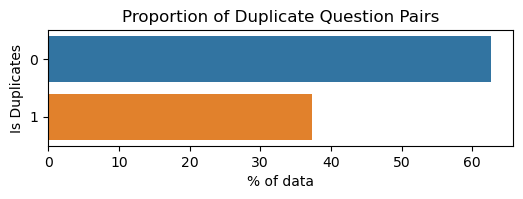

In [157]:
fig= plt.figure(figsize=(6,1.5))
sns.barplot(x=100*df_train['is_duplicate'].value_counts()/len(df_train),
            y=(100*df_train['is_duplicate'].value_counts()/len(df_train)).index,orient='h',).set(ylabel="Is Duplicates",xlabel="% of data",title="Proportion of Duplicate Question Pairs")
plt.show()

3. 检查是否有缺失值

In [158]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [159]:
ques2_list = df_train.loc[df_train['question1'].isnull(),'question2'].values
ques1_list = df_train.loc[df_train['question2'].isnull(),'question1'].values

display(df_train[df_train['question1'].isin(ques1_list)])
display(df_train.loc[df_train['qid2']==174364,:])

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

In [160]:
display(df_train[df_train['question2'].isin(ques2_list)])
display(df_train.loc[df_train['qid1']==493340,:])

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

删除3个缺失的问题对

In [161]:
df = df_train.loc[~df_train.isnull().any(axis=1),:].copy()
print("Any Rows with Missing Data: ",(df.isna().sum()>0).any())
df['question1'] = df.loc[:,'question1'].apply(lambda x: str(x).strip())
df['question2'] = df.loc[:,'question2'].apply(lambda x: str(x).strip())

Any Rows with Missing Data:  False


4. 检查整个语料库中唯一问题和重复问题的数量

In [162]:
questions_list = pd.concat([df['question1'] , df['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  73622
Number of Questions which are repeated:  6295
Total number of unique questions in dataset:  79917


5.重复问题的分布

In [163]:
rep_ques = questions_list.value_counts()[questions_list.value_counts()>1]
rep_ques

What are the best ways to lose weight?                                                                                    14
What are the best was to lose weight?                                                                                     12
How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption?                                12
What are some things new employees should know going into their first day at AT&T?                                        11
How can I lose weight quickly?                                                                                            11
                                                                                                                          ..
Why do people ask so many Googleable questions on Quora?                                                                   2
How do I stop my Husky/Border Collie puppy from chewing my socks?                                                          2


Maximum number of times a single question is repeated:  14



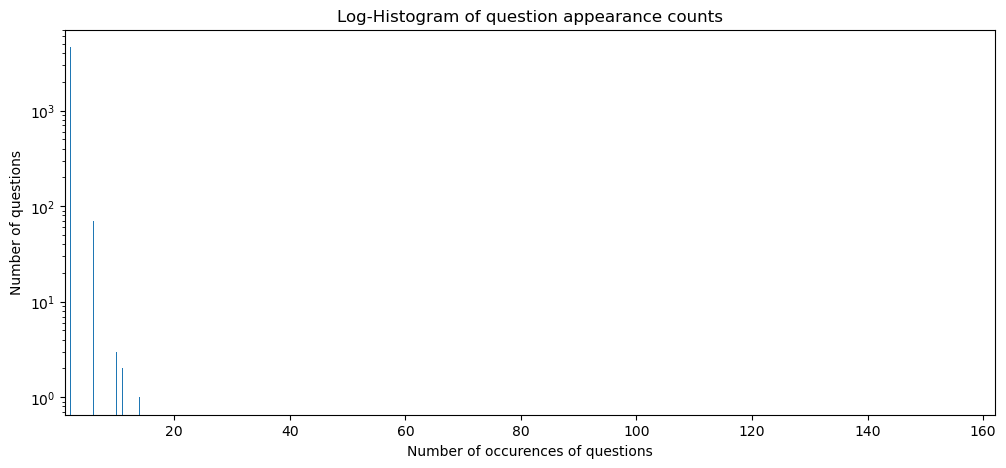

In [164]:
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(20, 3.5))
plt.hist(rep_ques, bins=160)
plt.yscale('log')

plt.xlim((1,162))
plt.title('Log-Histogram of question appearance counts')
plt.xlabel("Number of occurences of questions")
plt.ylabel("Number of questions")
print('Maximum number of times a single question is repeated:  {}\n'.format(max(rep_ques)))
plt.show()

In [165]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
math_q = [q  for q in document_corpus if '[math]' in q]

print("Percentage of Questions with '?' (not necessarily ending with): {0:.3f} %".format(100*len([q  for q in document_corpus if '?' in q])/len(document_corpus)))
print("Percentage of Questions not having '?': {0:.3f} %".format(100*len([q  for q in document_corpus if '?' not in q])/len(document_corpus)))
print("Number of Math based questions:  {0:3f} %".format(100*len(math_q)/len(document_corpus)))
print("Questions with multiple parts: {0:.3f} %".format(100*len([ q for q in document_corpus if len(q.split('?'))>2 ])/len(document_corpus) ))
print("\nExamples of Questions with subparts : ",[ q for q in document_corpus if len(q.split('?'))>2 ][0:2]) 
print("\nPersonal or Opinion-based questions: {0:.3f} %".format(100*len([q for q in document_corpus if ('you' in q) or (' i ' in q) ])/len(document_corpus)))
print("\nSome Personal Or Opinion-based questions: ", [q for q in document_corpus if 'you' in q][:2])

Percentage of Questions with '?' (not necessarily ending with): 99.877 %
Percentage of Questions not having '?': 0.123 %
Number of Math based questions:  0.130135 %
Questions with multiple parts: 5.356 %

Examples of Questions with subparts :  ['Who is Nolan Ryan and how many times has he won the Cy Young Award? How many records does he still hold?', 'Which actors have played Tarzan in movies and TV? Who was the best?']

Personal or Opinion-based questions: 12.678 %

Some Personal Or Opinion-based questions:  ['When did you have your first orgasm?', 'Is it possible for humans to catch fleas from their dog and how can you prevent this from happening?']


6. 文本预处理

In [166]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [167]:
%%time
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
print("Train Data Text Pre-processing Done!")

c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Train Data Text Pre-processing Done!
CPU times: total: 10.3 s
Wall time: 14.5 s


100%|██████████| 14/14 [01:38<00:00,  7.02s/it]


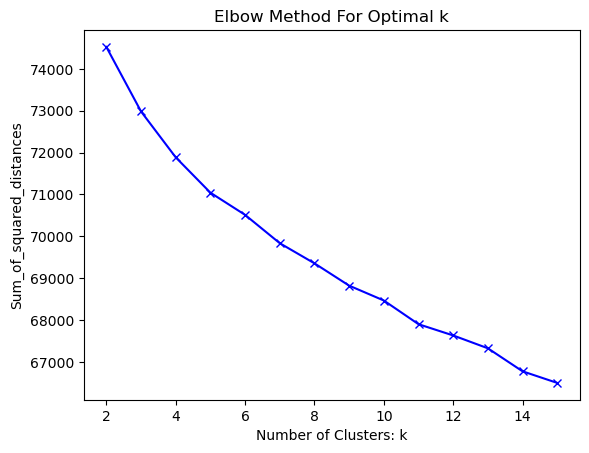

Finding Optima*l Cluster Number Done!
CPU times: total: 3min 36s
Wall time: 1min 40s


<Figure size 640x480 with 0 Axes>

In [168]:
%%time

# 获取所有问题并去重
document_corpus = list( set(list(df['question1']) + list(df['question2'])) )

# 初始化 TfidfVectorizer，并将文本转换为 Tfidf 矩阵
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(document_corpus)

# 初始化 Sum_of_squared_distances 数组，用于记录不同聚类数对应的误差平方和（SSE）
Sum_of_squared_distances = []

# 遍历不同的聚类数
for k in tqdm(range(2,16)):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)

# 绘制 Elbow 图
plt.plot(range(2,16), Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters: k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 输出找到最佳聚类数的提示信息，并保存图片
print("Finding Optima*l Cluster Number Done!")
plt.savefig("cluster_analysis.png")

在这里，我们看到，当聚类数=5时，有一个轻微的下降，之后，平方距离之和呈线性下降。因此，我们将最佳群集数定为5，并将群集映射到相应的问题上。

In [169]:
# 将问题内容进行合并去重，得到文本语料库
document_corpus = list(set(list(df['question1']) + list(df['question2'])))

# 创建一个数据框存储文本和对应的聚类标签
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})

# 将文本转化为TF-IDF特征向量，并取前1000个特征，包括单个单词和两个单词的组合
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(questions_cluster['questions'].values)

# 对特征向量进行标准化处理，将其缩放到均值为0，标准差为1的范围
sc_x = StandardScaler()
std_x = sc_x.fit_transform(x.toarray())
print("standardised")

standardised


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 12%|█▎        | 1/8 [05:37<39:19, 337.06s/it]c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|██▌       | 2/8 [11:26<34:27, 344.61s/it]c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 38%|███▊      | 3/8 [17:39<29:46, 357.38s/it]c:\Users\19620\AppData\Local\P

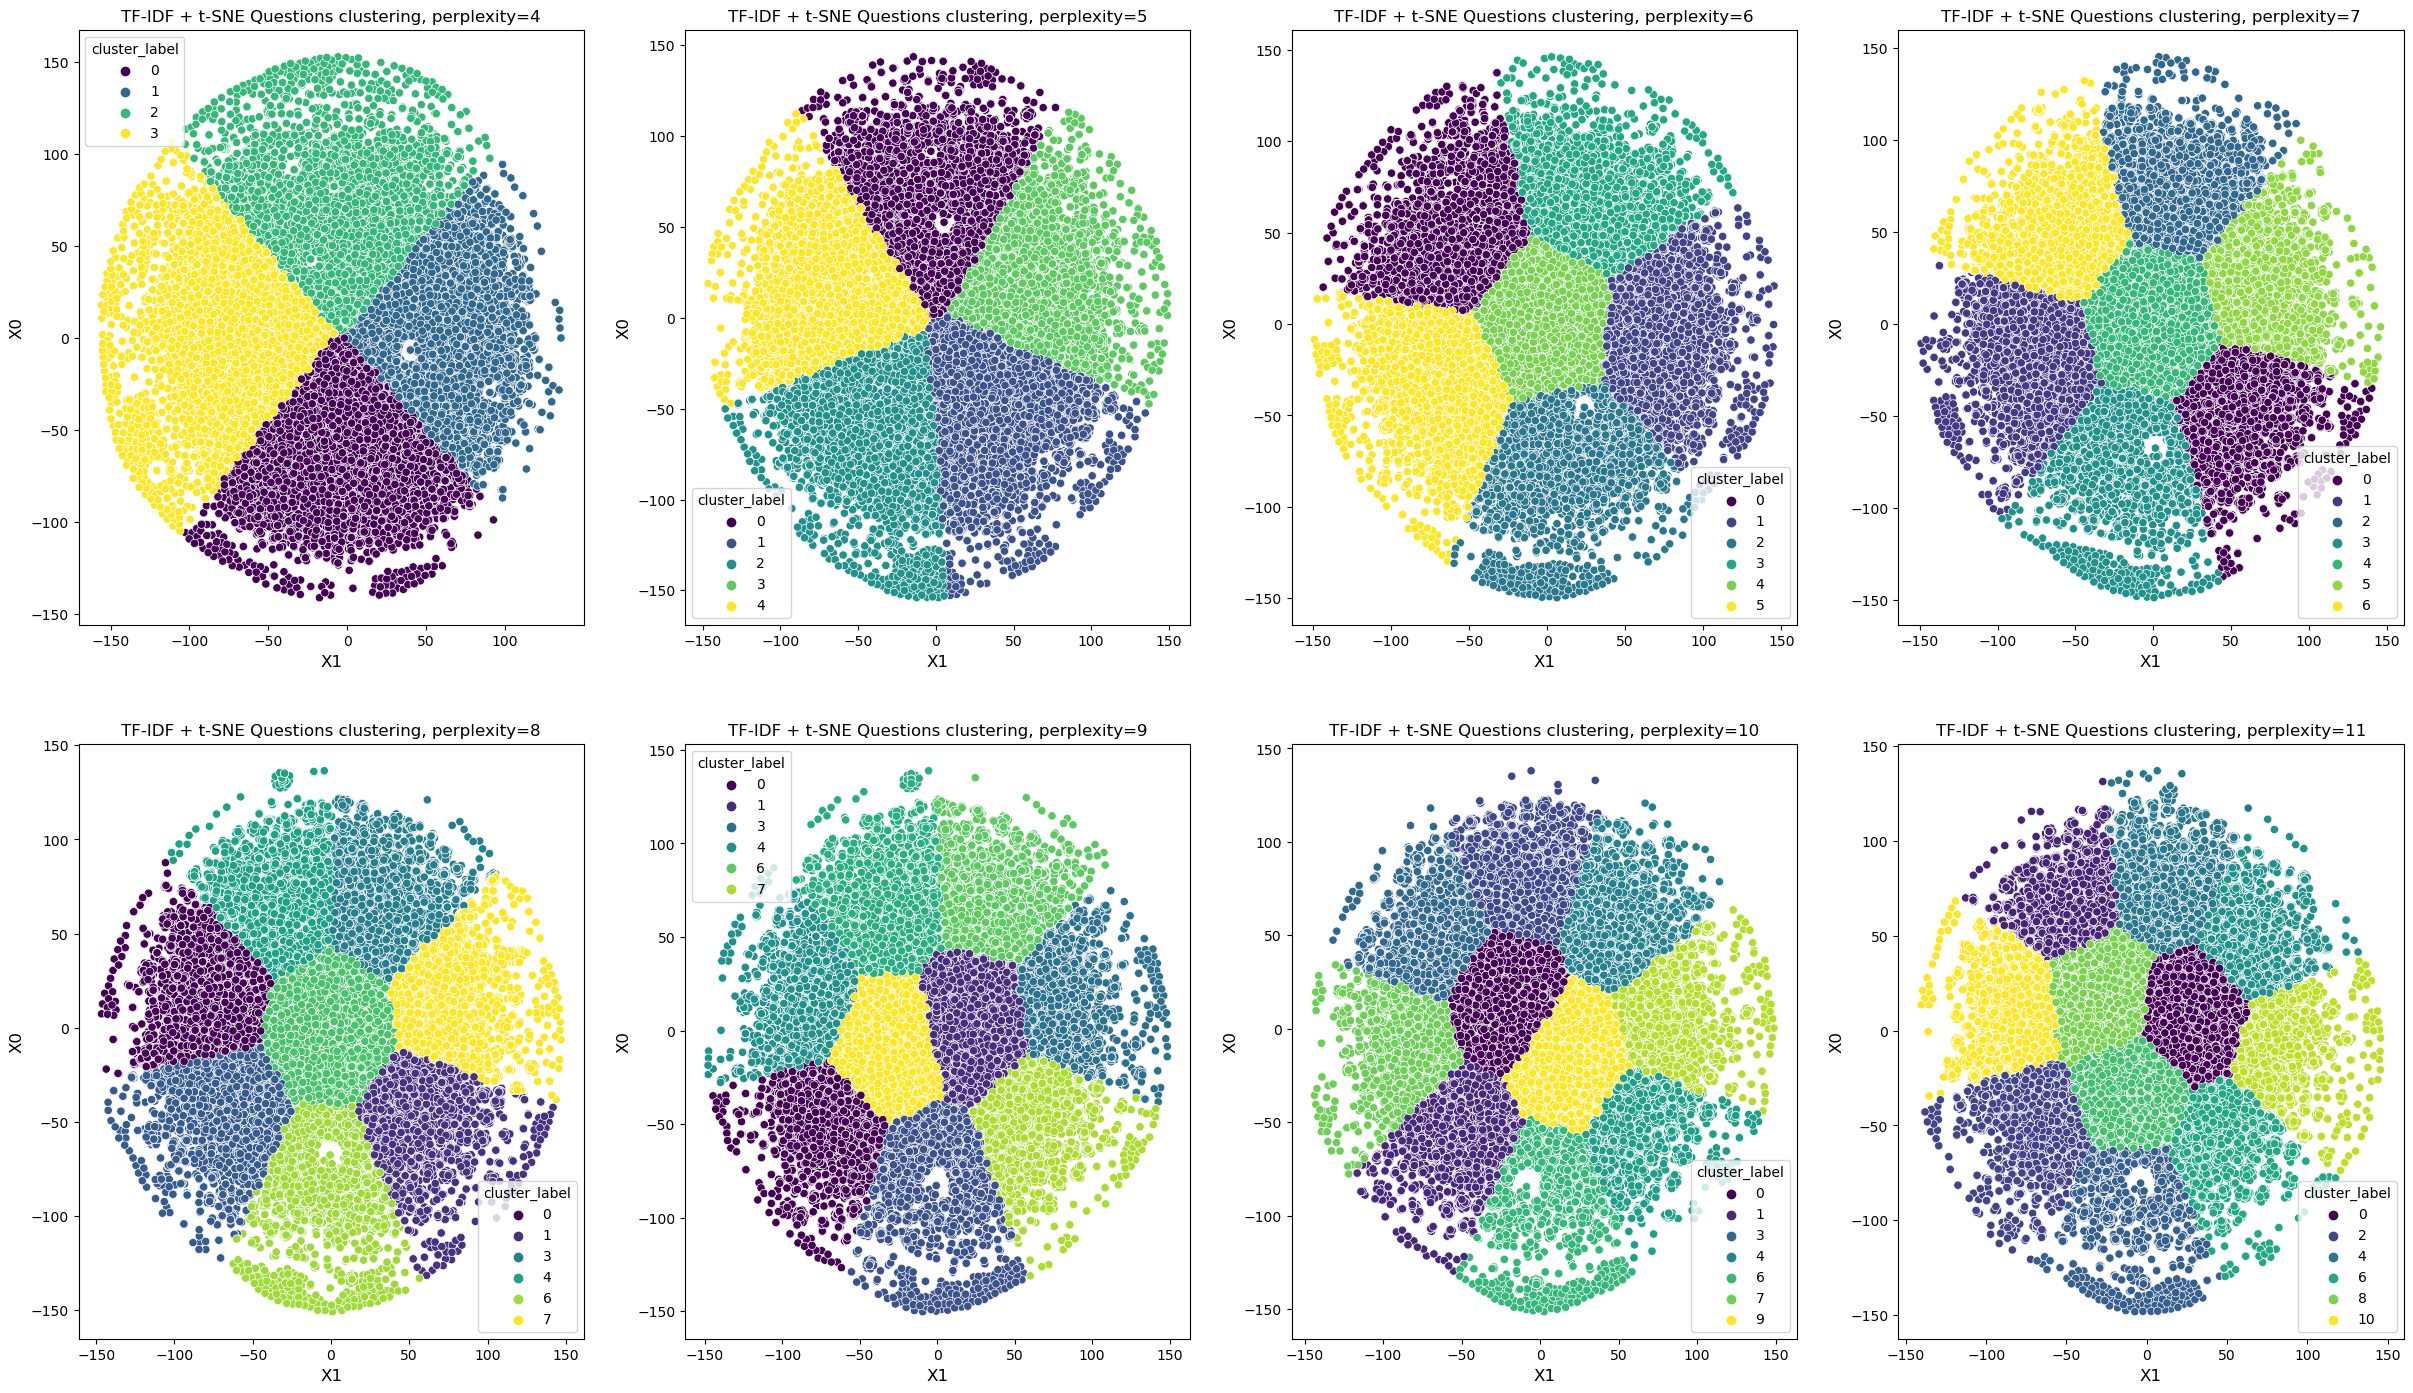

In [173]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

# 使用t-SNE算法进行聚类，并将结果在二维平面上可视化
# 遍历多个不同的聚类数值（4到11），每个聚类结果在二维平面上可视化
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,17))
i=1

# Loop over different perplexity values for t-SNE algorithm
for p in tqdm(range(4,12)):
    # Use t-SNE algorithm to transform feature vectors into 2D embeddings
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne_vecs = tsne.fit_transform(std_x)

    # 使用KMeans聚类算法获取聚类标签
    kmeans = KMeans(n_clusters=p, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_vecs)

    # 设置标注
    questions_cluster['cluster_label'] = cluster_labels

    x0 = tsne_vecs[:, 0]
    x1 = tsne_vecs[:, 1]
    
    # Plot the 2D embeddings with different colors for different clusters
    plt.subplot(2,4,p-3)
    plt.title("TF-IDF + t-SNE Questions clustering, perplexity="+str(p), fontdict={"fontsize": 12})
    plt.xlabel("X1", fontdict={"fontsize": 12})
    plt.ylabel("X0", fontdict={"fontsize": 12})
    # 可视化tsne降维后的结果
    sns.scatterplot(data=questions_cluster, x=x1, y=x0, hue='cluster_label', palette="viridis")

100%|██████████| 8/8 [00:33<00:00,  4.13s/it]


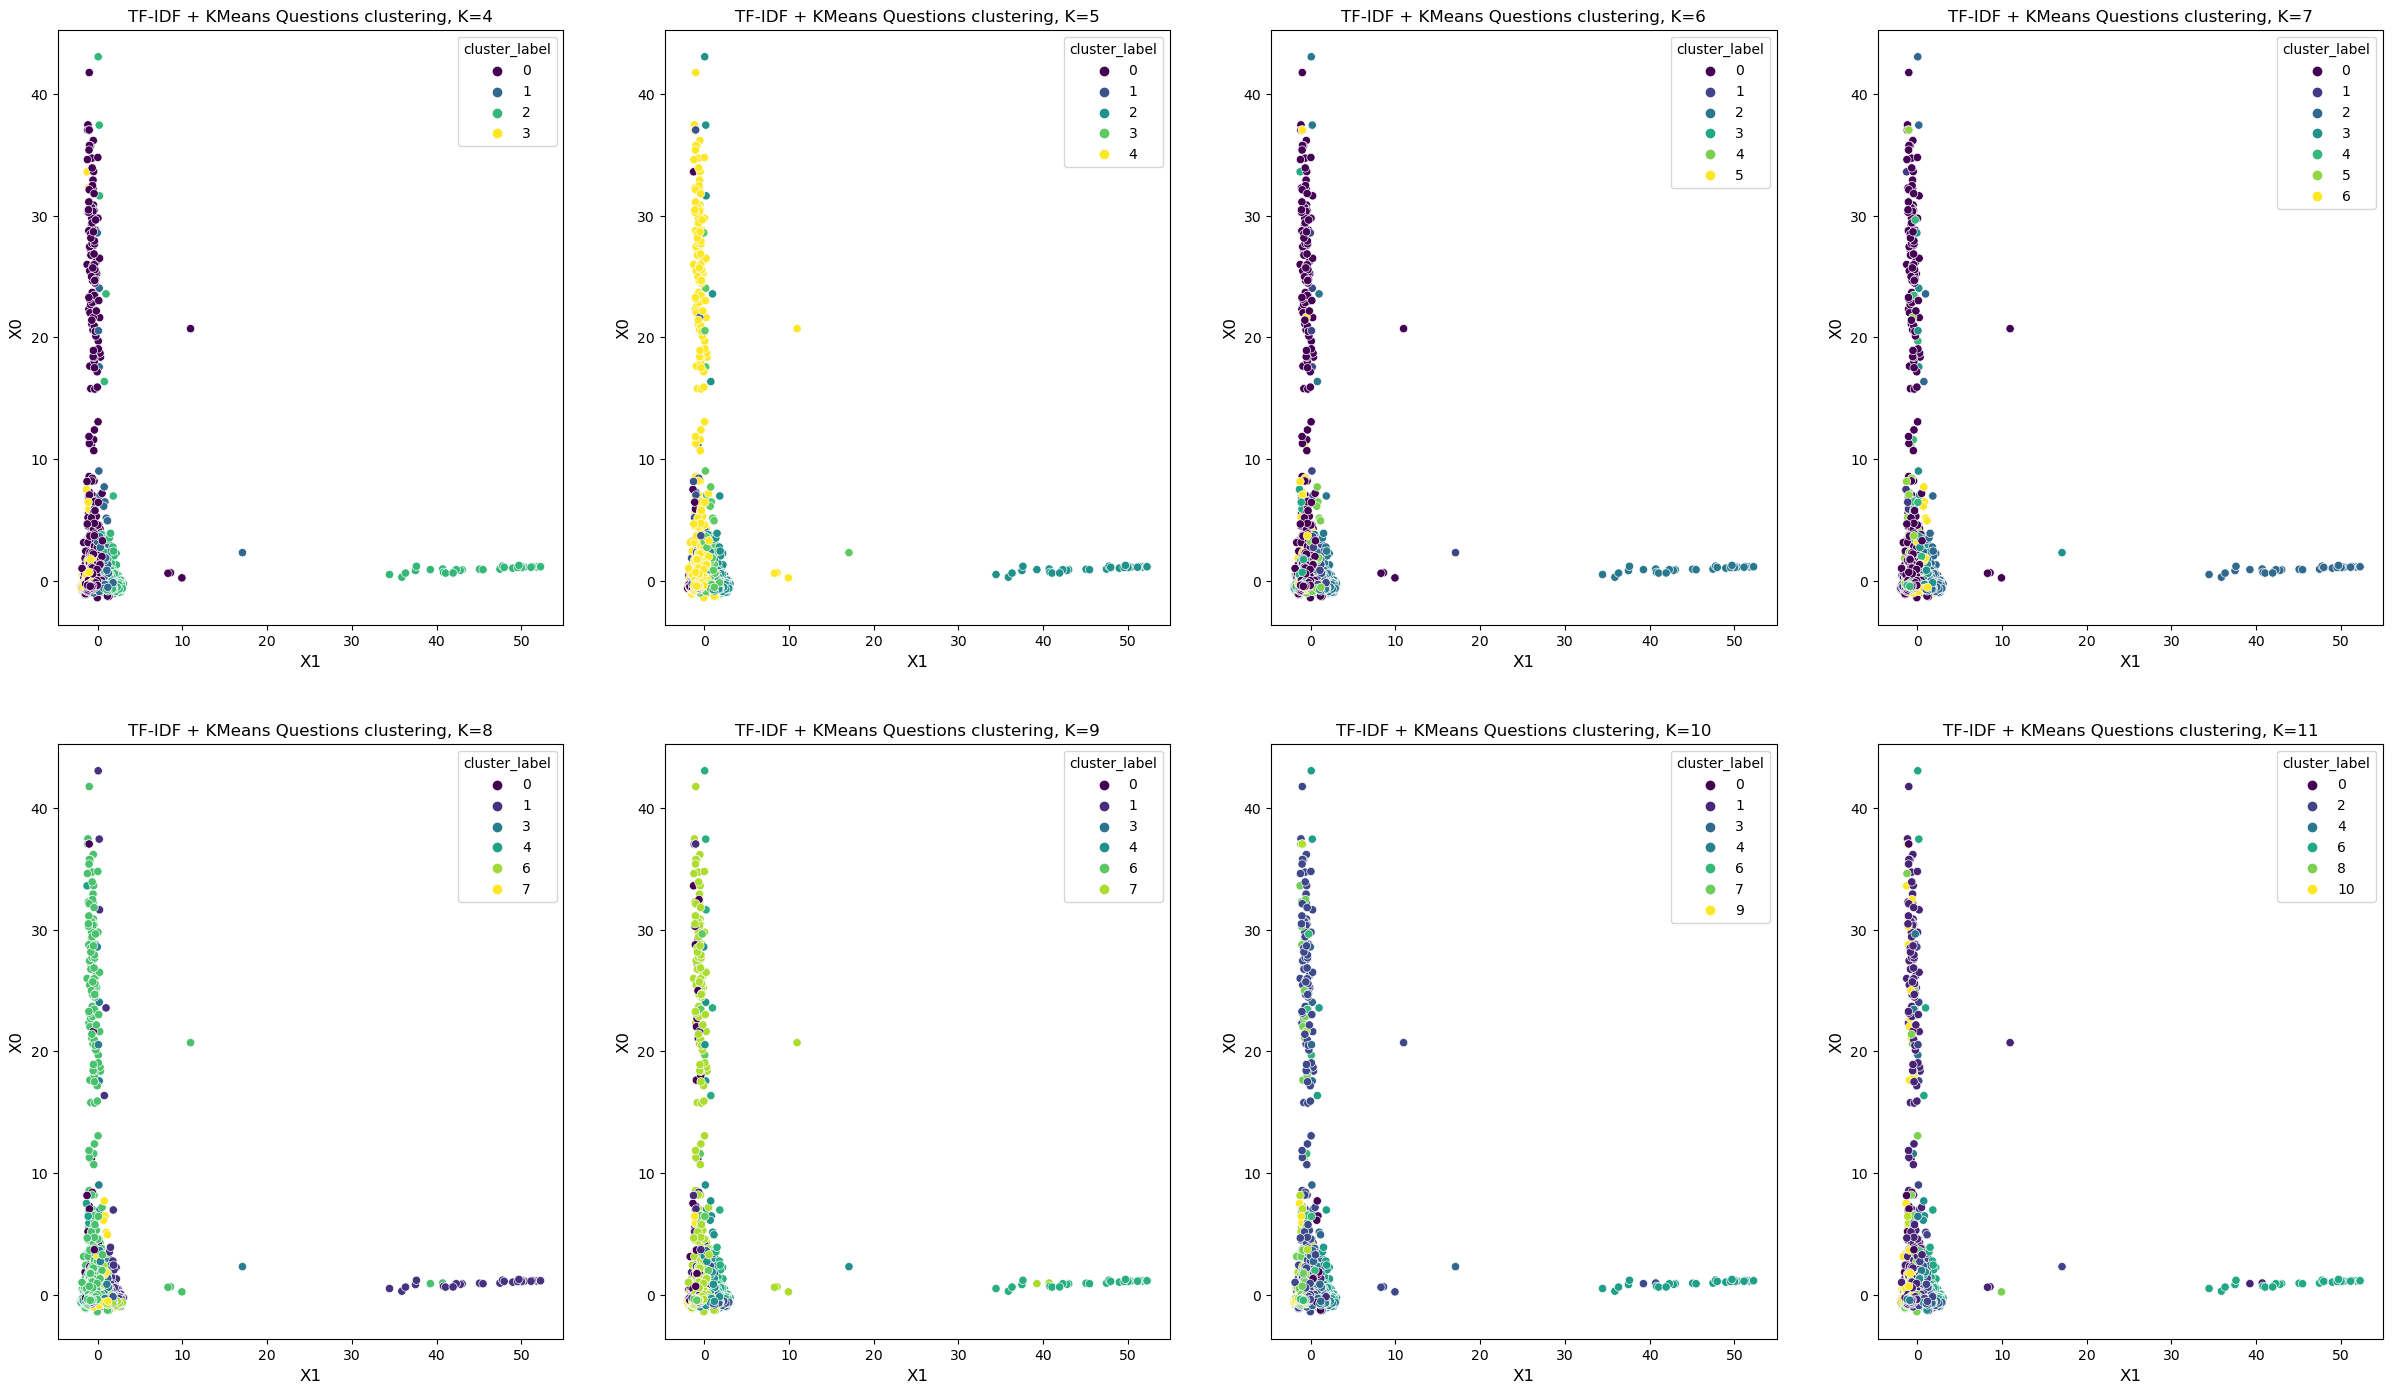

CPU times: total: 2min 28s
Wall time: 37.8 s


In [ ]:
%%time
# 使用KMeans算法进行聚类，并将结果在二维平面上可视化
# 遍历多个不同的聚类数值（4到11），每个聚类结果在二维平面上可视化
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,17))
i=1
for k in tqdm(range(4,12)): # tqdm是一个进度条库，可以用来显示循环的进度
    # 创建KMeans模型，并训练模型
    km = KMeans(n_clusters=k, max_iter=500, n_init=20)
    km = km.fit(x)

    # 将每个问题的聚类标签存储在数据框中
    questions_cluster['cluster_label'] = km.labels_

    # 使用PCA算法将特征向量降维到二维平面上
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(std_x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    questions_cluster['x0'] = x0
    questions_cluster['x1'] = x1

    # 在一个2x4的子图中绘制散点图
    plt.subplot(2,4,i)
    plt.title("TF-IDF + KMeans Questions clustering, K="+str(k), fontdict={"fontsize": 12})
    plt.xlabel("X1", fontdict={"fontsize": 12})
    plt.ylabel("X0", fontdict={"fontsize": 12})
    sns.scatterplot(data=questions_cluster, x='x1', y='x0', hue='cluster_label', palette="viridis")
    i+=1


# 显示图像
plt.show()

8.不同问题群的词云

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


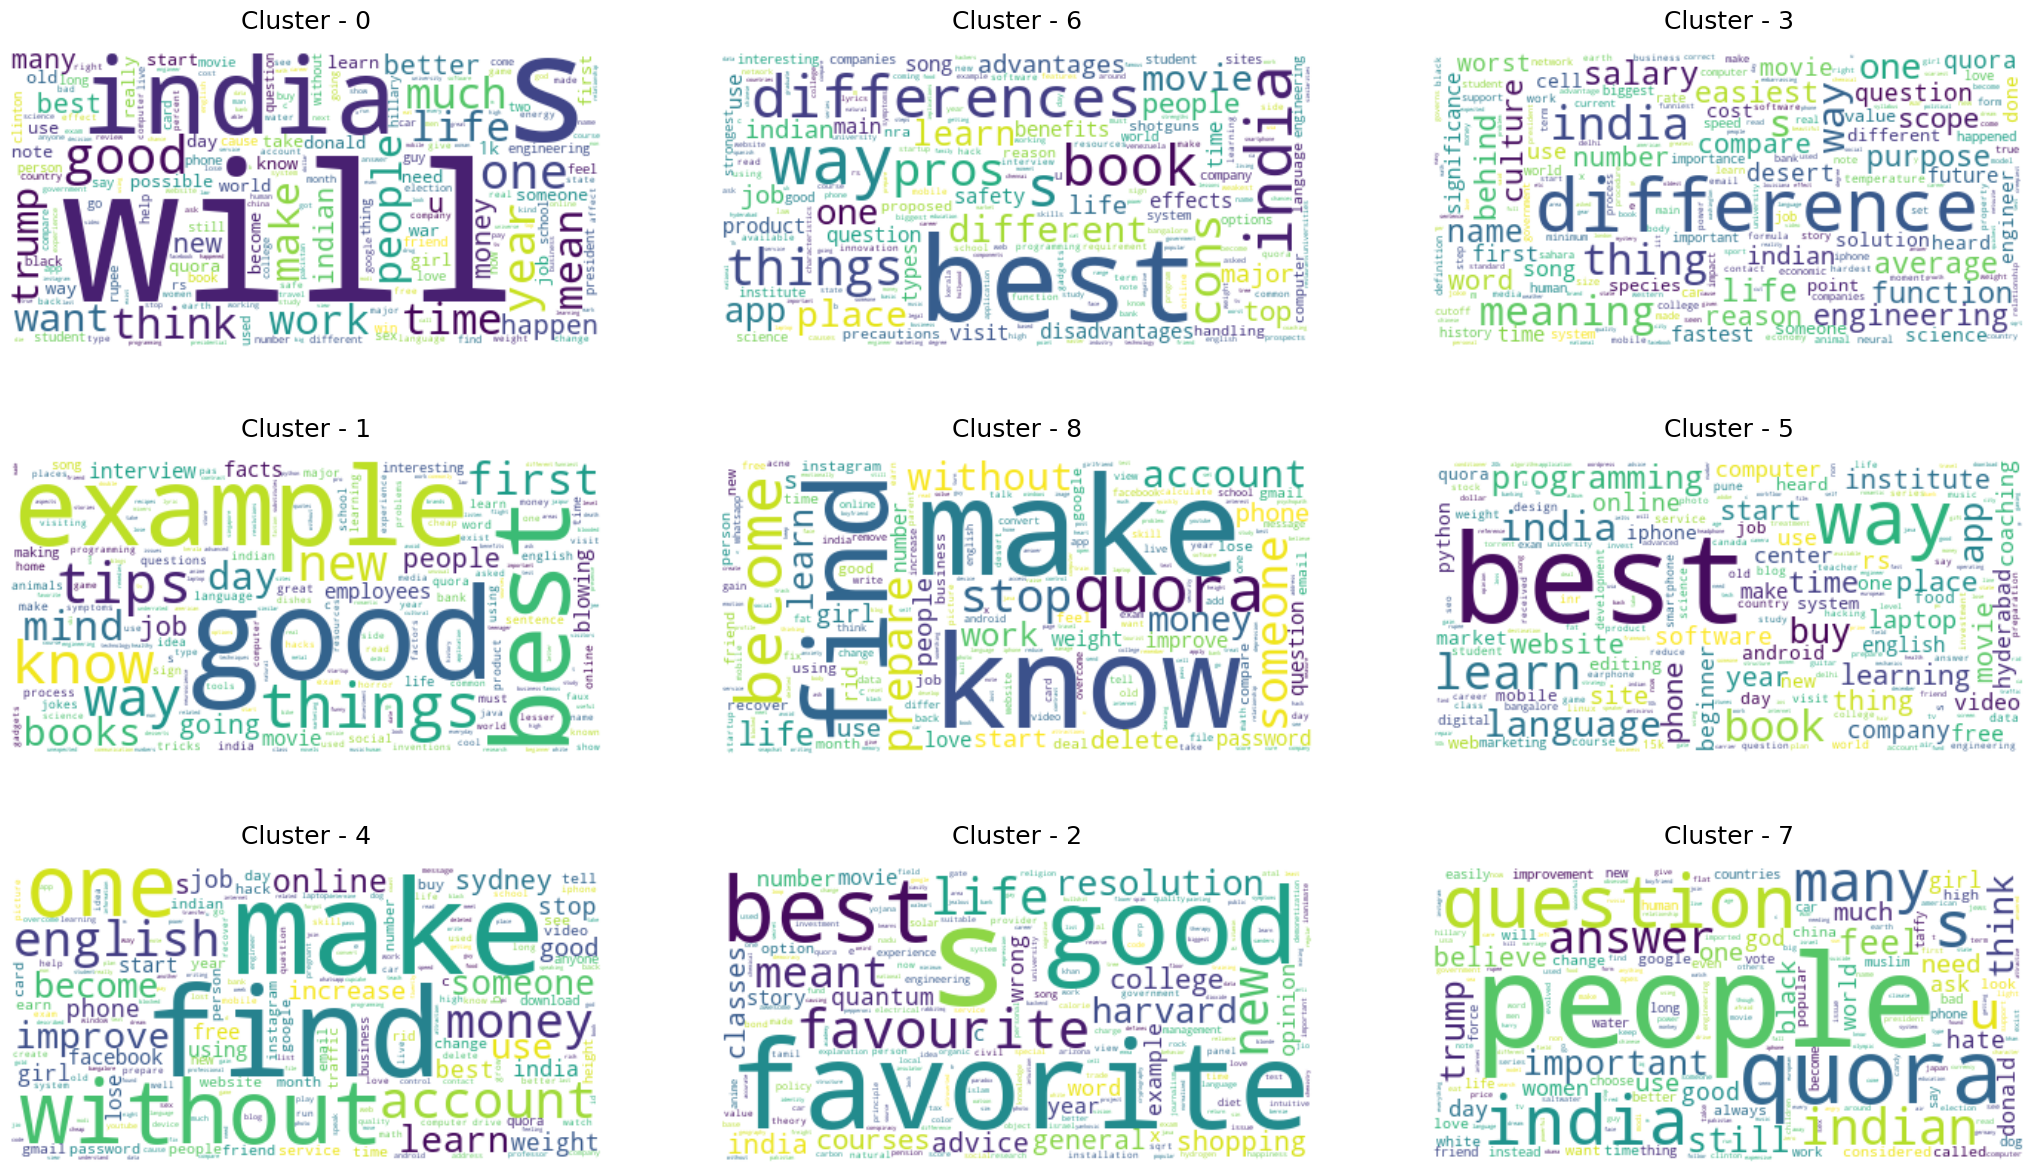

CPU times: total: 37 s
Wall time: 13.2 s


In [ ]:
%%time

# 获取问题的语料库
document_corpus = list(set(list(df['question1']) + list(df['question2'])))

# 创建数据帧用于存储问题和聚类标签
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})

# 对语料库进行特征提取，生成文档-词条矩阵
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))
x = vectorizer.fit_transform(questions_cluster['questions'].values)

# 对文档进行K-Means聚类
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
questions_cluster['cluster_label'] = km.labels_


# 创建画布用于展示聚类结果的词云图
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(26,15))

# 对每个聚类进行处理
i=1
for cluster in tqdm(questions_cluster['cluster_label'].unique()):
    # 从当前聚类中获取所有问题，将其转化为字符串并生成词云
    questions = " ".join(questions_cluster[questions_cluster['cluster_label']==cluster]['questions'].values)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(questions)
    
    # 从当前聚类中获取所有问题，将其转化为字符串并生成词云
    plt.subplot(3,3,i)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title("Cluster - "+str(cluster), fontsize=18,pad=17)
    plt.axis("off")
    i+=1
    
# 显示画布
plt.show()

In [ ]:
len(['how' in q for q in questions_cluster.loc[questions_cluster['cluster_label']==1,['questions']].values]),

(713,)

In [ ]:
print(len(['what' in q for q in questions_cluster.loc[questions_cluster['cluster_label']==2,['questions']].values]))
questions_cluster.loc[questions_cluster['cluster_label']==2,['questions']].values[10:],questions_cluster.loc[questions_cluster['cluster_label']==3,['questions']].values[10:] 

626


(array([['what is best career option for electronics   instrumentation engineering'],
        ['what is jon stewart like in person'],
        ['what is jack dorsey like'],
        ['what is meant by freight'],
        ['what is better   engineering or medical'],
        ['what is abstract expressionism in painting'],
        ['what is a least natural number'],
        ['what is drug rehab like'],
        ['is idealism naive'],
        ['what is our stance against pakistan'],
        ['what is an intuitive explanation of gradient boosting'],
        ['what is called a black hole'],
        ['what is a cool video idea'],
        ['what is banana bond'],
        ['what is your creative new year s resolution for 2017'],
        ['what is a poll tax'],
        ['what is your most embarrassing moment in public'],
        ['what is an actinomorphic flower'],
        ['what is africa standpoint on trade and protection'],
        ['what is your take on urjit patel as the new rbi governor'],
   

In [ ]:
questions_cluster.loc[questions_cluster['cluster_label']==4,['questions']].values[10:],questions_cluster.loc[questions_cluster['cluster_label']==5,['questions']].values[10:] 

(array([['can you feed pork rib bones to dogs'],
        ['where can i get the jacket that ranbir kapoor is wearing in song  matargashti'],
        ['how can i improve my english pronunciation'],
        ...,
        ['i want to start my clothes boutique in india  from where can i buy cheap wholesale clothes'],
        ['where can i see a lamborghini in bangalore'],
        ['where can i find a postal code']], dtype=object),
 array([['what is the best app for photo and video editing'],
        ['what is the best workflow for using adobe fireworks for iphone retina ui design'],
        ['what is the best reply to  thank you  in formal and casual situations'],
        ['what is the best mobile advertising you have seen'],
        ['what is the best website for consumer product reviews'],
        ['what is the best way to loose weight quickly'],
        ['which is the best motivational movie ever'],
        ['what is the best hostel booking affiliate program'],
        ['what is the best 

In [ ]:
# 将问题所属的聚类标签加入到原始数据集df中，并删除不必要的列
# 然后重命名标签列
df = pd.merge( left=pd.merge(left=df, right=questions_cluster, left_on="question1", right_on="questions"), right=questions_cluster , left_on="question2", right_on="questions")
df.drop(["questions_x","questions_y"], axis=1, inplace=True)
df.rename(columns={'cluster_label_x':'q1_cluster','cluster_label_y':'q2_cluster'}, inplace=True)

# 打印数据集的前4个样本
print("Train Questions cluster labelling Done!")
df.head(4)

Train Questions cluster labelling Done!


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve it   

                                           question2  is_duplicate  \
0  what is the step by step guide to invest in sh...             0   
1  what would happen if the indian government sto...             0   
2  how can internet speed be increased by hacking...             0   
3  find the remainder when 23  24   math  is divi...             0   

   q1_cluster  q2_cluster  
0           3           3  
1           3           0  
2           4           4  
3           4           0

9. 基本特征提取

In [ ]:
%%time
df = pd.merge( pd.merge(df,pd.DataFrame({'qid1':df['qid1'].value_counts().index.values,
                                         'freq_qid1':df['qid1'].value_counts().values}), on='qid1',how="left"),pd.DataFrame({'qid2':df['qid2'].value_counts().index.values,
                                                                                                                             'freq_qid2':df['qid2'].value_counts().values}) ,on='qid2', how='left')
df['is_duplicate'] = df['is_duplicate'].apply(lambda x: "Yes" if x==1 else "No")
df.loc[:,['q1_length']] = df['question1'].apply(lambda x: len(x)).values
df.loc[:,['q2_length']] = df['question2'].apply(lambda x: len(x)).values
df['same_cluster'] = df[['q1_cluster','q2_cluster']].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)
df['q1_wordsCount'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_wordsCount'] = df['question2'].apply(lambda x: len(x.split(" ")))
df['common_wordsCount'] = df[['question1','question2']].apply(lambda x: len(set(x[0].split(" ")).intersection(set(x[1].split(" ")))) , axis=1 )
df['q1_freq+q2_freq'] = df['freq_qid1']+df['freq_qid2']
df['q1_freq-q2_freq'] = abs(df['freq_qid1']-df['freq_qid2'])
df['total_word_share'] = 2*df['common_wordsCount']/(df['q1_wordsCount']+df['q2_wordsCount'])
print("Train Data Basic Feature Engineering Done!")
df.head(2)

Train Data Basic Feature Engineering Done!
CPU times: total: 188 ms
Wall time: 185 ms


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           3   
1  what would happen if the indian government sto...           No           3   

   q2_cluster  freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  \
0           3          1          1         65         56             1   
1           0          1          1         50         87             0   

   q1_wordsCount  q2_wordsCount  common_wordsCount  q1_freq+q2_freq  \
0             14             12                 11                2   
1             12             17                  8                2   

   q1_freq-q2_freq  total_word_share  
0                0          0.846154  
1                0          0.551724

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_cluster', 'q2_cluster', 'freq_qid1', 'freq_qid2', 'q1_length',
       'q2_length', 'same_cluster', 'q1_wordsCount', 'q2_wordsCount',
       'common_wordsCount', 'q1_freq+q2_freq', 'q1_freq-q2_freq',
       'total_word_share'],
      dtype='object')

10. 高级文本特征提取

In [ ]:
%%time
STOP_WORDS = stopwords.words("english")
epsilon = 0.001
       
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def advanced_featureExtract(q1,q2):
    
    q1_tokens = q1.split(" ")
    q2_tokens = q2.split(" ")
    
    q1_stopwords = [word for word in q1_tokens if word in STOP_WORDS]
    q2_stopwords = [word for word in q2_tokens if word in STOP_WORDS]
    
    q1_words = [word for word in q1_tokens if word not in STOP_WORDS]
    q2_words = [word for word in q2_tokens if word not in STOP_WORDS]
        
    common_words = list(set(q1_words).intersection(set(q2_words)))
    common_stopwords = list(set(q1_stopwords).intersection(set(q2_stopwords)))
    common_tokens = list(set(q1_tokens).intersection(set(q2_tokens)))
    
    com_words_count_min = len(common_words)/(epsilon + min(len(q2_words), len(q1_words)) )
    com_words_count_max = len(common_words)/(epsilon + max(len(q2_words), len(q1_words)) )
    
    com_stopwords_count_min = len(common_words)/(epsilon + min(len(q2_stopwords), len(q1_stopwords)) )
    com_stopwords_count_max = len(common_stopwords)/(epsilon + max(len(q2_stopwords), len(q1_stopwords)) )
    
    com_token_count_min = len(common_tokens)/(epsilon + min(len(q2_tokens), len(q1_tokens)) )
    com_token_count_max = len(common_tokens)/(epsilon + max(len(q2_tokens), len(q1_tokens)) )
    
    last_word_eq  = 1 if q2_tokens[-1] == q1_tokens[-1] else 0
    first_word_eq = 1 if q2_tokens[0]  == q1_tokens[0]  else 0
    
    abs_len_diff = abs(len(q2_tokens) - len(q1_tokens))
    mean_len = (len(q2_tokens) + len(q1_tokens))/2
    
    # print(q1)
    # print(q2)
    # print(list(distance.lcsubstrings(q1, q2)))
    longest_substring_ratio = get_longest_substr_ratio(q1, q2)
    
    return com_words_count_min, com_words_count_max, com_stopwords_count_min,  com_stopwords_count_max, com_token_count_min, com_token_count_max,  last_word_eq, first_word_eq, abs_len_diff, mean_len, longest_substring_ratio
       
token_features = df.apply(lambda x: advanced_featureExtract(x["question1"], x["question2"]), axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))
df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
df["mean_len"]      = list(map(lambda x: x[9], token_features))
df["longest_substring_ratio"] = list(map(lambda x: x[10], token_features))
print("Train Data Advanced Feature Engg Done!")
df.head(2)

Train Data Advanced Feature Engg Done!
CPU times: total: 3.28 s
Wall time: 4.81 s


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           3   
1  what would happen if the indian government sto...           No           3   

   q2_cluster  freq_qid1  freq_qid2  ...   cwc_max   csc_min  csc_max  \
0           3          1          1  ...  0.714184  0.833194  0.85702   
1           0          1          1  ...  0.416632  0.999800  0.59988   

    ctc_min   ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.916590  0.785658             0              1             2      13.0   
1  0.666611  0.470561             0              1             5      14.5   

   longest_substring_ratio  
0                 0.982456  
1                 0.588235  

[2 rows x 30 columns]

11. 模糊文本相似性特征提取

In [ ]:
%%time

# 使用fuzz库中的ratio()函数，对两个问题字符串进行模糊匹配，并计算匹配分数
df['fuzz_ratio']           = df[['question1','question2']].apply(lambda x: fuzz.ratio(x[0],x[1]),           axis=1)

# 使用fuzz库中的partial_ratio()函数，对两个问题字符串进行部分模糊匹配，并计算匹配分数
df['fuzz_partial_ratio']   = df[['question1','question2']].apply(lambda x: fuzz.partial_ratio(x[0],x[1]),   axis=1)

# 使用fuzz库中的token_sort_ratio()函数，对两个问题字符串进行单词排序后进行模糊匹配，并计算匹配分数
df['fuzz_token_sort_ratio']= df[['question1','question2']].apply(lambda x: fuzz.token_sort_ratio(x[0],x[1]),axis=1)

# 使用fuzz库中的token_set_ratio()函数，对两个问题字符串进行集合运算后进行模糊匹配，并计算匹配分数
df['fuzz_token_set_ratio'] = df[['question1','question2']].apply(lambda x: fuzz.token_set_ratio(x[0],x[1]), axis=1)

# 使用fuzz库中的WRatio()函数，对两个问题字符串进行模糊匹配，并根据单词权重进行计算匹配分数
df['fuzz_WRatio']          = df[['question1','question2']].apply(lambda x: fuzz.WRatio(x[0],x[1]),          axis=1)
print("Train Data Fuzzy Ratios done!")
df.head(2)

Train Data Fuzzy Ratios done!
CPU times: total: 1.2 s
Wall time: 1.74 s


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           3   
1  what would happen if the indian government sto...           No           3   

   q2_cluster  freq_qid1  freq_qid2  ...  last_word_eq  first_word_eq  \
0           3          1          1  ...             0              1   
1           0          1          1  ...             0              1   

   abs_len_diff  mean_len  longest_substring_ratio  fuzz_ratio  \
0             2      13.0                 0.982456          93   
1             5      14.5                 0.588235          66   

   fuzz_partial_ratio  fuzz_token_sort_ratio  fuzz_token_set_ratio  \
0                 100                     93                   100   
1                  74                     63                    86   

   fuzz_WRatio  
0           95  
1           86  

[2 rows x 35 columns]

12. 从TF-IDF文本向量中找到余弦相似性

In [ ]:
%%time

# 将两个问题列合并为一个列表
document_corpus = list(df['question1'])+list(df['question2'])

# 计算tf-idf向量
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(document_corpus)

# 将所有问题分为两部分，分别用于计算向量
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
# 对于每一对问题，计算其余向量的点积
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

# 将余弦相似度添加为新的列
df['cosine_similarity'] = ques_pair_vectors
print("Train Data cosine_similarity Done !")
df.head(2)

100%|██████████| 8001/8001 [00:02<00:00, 3257.75it/s]

Train Data cosine_similarity Done !
CPU times: total: 1.91 s
Wall time: 2.64 s


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           3   
1  what would happen if the indian government sto...           No           3   

   q2_cluster  freq_qid1  freq_qid2  ...  first_word_eq  abs_len_diff  \
0           3          1          1  ...              1             2   
1           0          1          1  ...              1             5   

   mean_len  longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
0      13.0                 0.982456          93                 100   
1      14.5                 0.588235          66                  74   

   fuzz_token_sort_ratio  fuzz_token_set_ratio  fuzz_WRatio  cosine_similarity  
0                     93                   100           95           0.977874  
1                     63                    86           86           0.702681  

[2 rows x 36 columns]

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_cluster', 'q2_cluster', 'freq_qid1', 'freq_qid2', 'q1_length',
       'q2_length', 'same_cluster', 'q1_wordsCount', 'q2_wordsCount',
       'common_wordsCount', 'q1_freq+q2_freq', 'q1_freq-q2_freq',
       'total_word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substring_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_WRatio', 'cosine_similarity'],
      dtype='object')

In [ ]:
df.isna().sum()

id                         0
qid1                       0
qid2                       0
question1                  0
question2                  0
is_duplicate               0
q1_cluster                 0
q2_cluster                 0
freq_qid1                  0
freq_qid2                  0
q1_length                  0
q2_length                  0
same_cluster               0
q1_wordsCount              0
q2_wordsCount              0
common_wordsCount          0
q1_freq+q2_freq            0
q1_freq-q2_freq            0
total_word_share           0
cwc_min                    0
cwc_max                    0
csc_min                    0
csc_max                    0
ctc_min                    0
ctc_max                    0
last_word_eq               0
first_word_eq              0
abs_len_diff               0
mean_len                   0
longest_substring_ratio    0
fuzz_ratio                 0
fuzz_partial_ratio         0
fuzz_token_sort_ratio      0
fuzz_token_set_ratio       0
fuzz_WRatio   

13. 特征标准化

In [ ]:
# 复制数据集
x= df.copy()

# 去除不需要的列
x.drop(['id','qid1','qid2','question1','question2','is_duplicate','q1_cluster', 'q2_cluster'], axis=1, inplace=True)

# 对数值特征进行标准化处理
# 在第0列插入一列值都为1的常数列
sc_x = StandardScaler()
x.insert(loc=0, column='x0', value=[1]*len(x))
x.iloc[:,1:-1] = sc_x.fit_transform(x.iloc[:,1:-1])

# 将目标变量转换为0/1二分类
y=df['is_duplicate'].apply(lambda x: 0 if x=="No" else 1)

# 输出数据集和目标变量的形状
x.shape, y.shape

((8001, 29), (8001,))

14. 逻辑回归模型

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 设定 epsilon 的值
eps=0.001

# 计算模型的损失函数
def model_lg_loss(model, x_cv, y_cv):
    lg_loss=pd.DataFrame(model.predict_proba(x_cv), index=range(len(y_cv)))
    lg_loss['y_cv']=y_cv.values 
    return sum(lg_loss.apply(lambda x: -np.log(eps + x[int(x.values[-1])]) if int(x.values[-1])==1 else 0, axis=1).values)/len(y_cv)


15.不同分类模型性能比较

  0%|          | 0/6 [00:00<?, ?it/s]

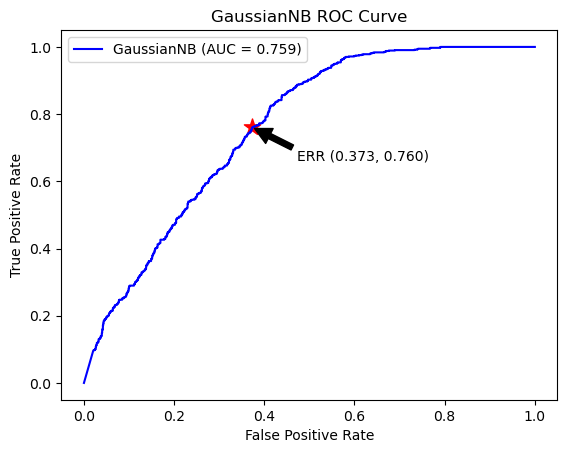

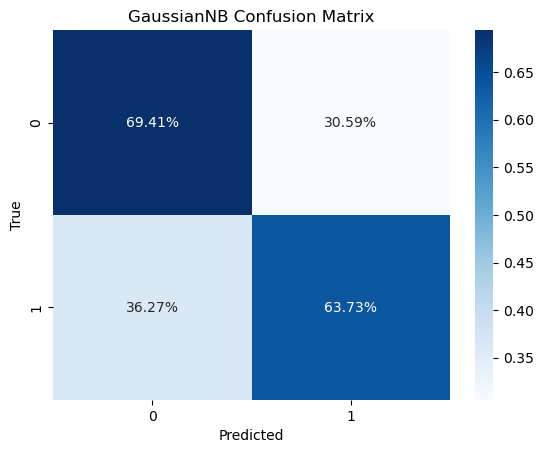

 17%|█▋        | 1/6 [00:00<00:01,  2.98it/s]

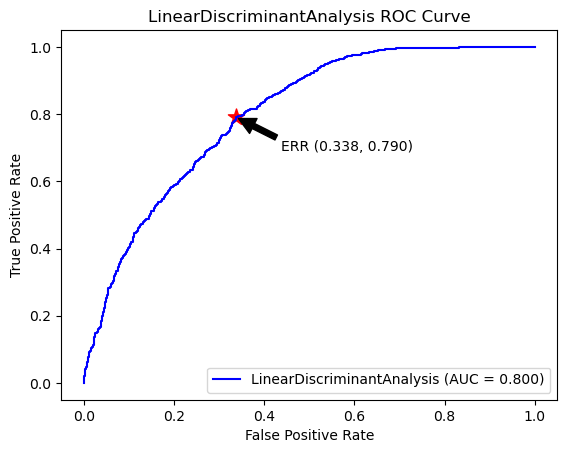

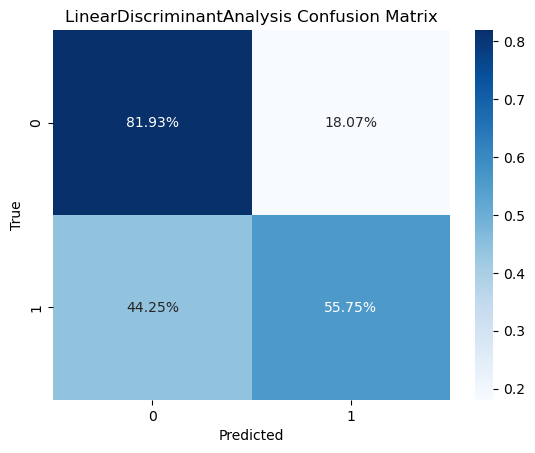

 33%|███▎      | 2/6 [00:00<00:01,  2.66it/s]

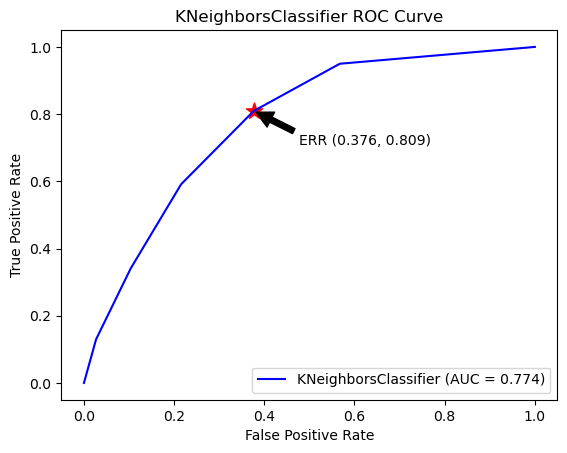

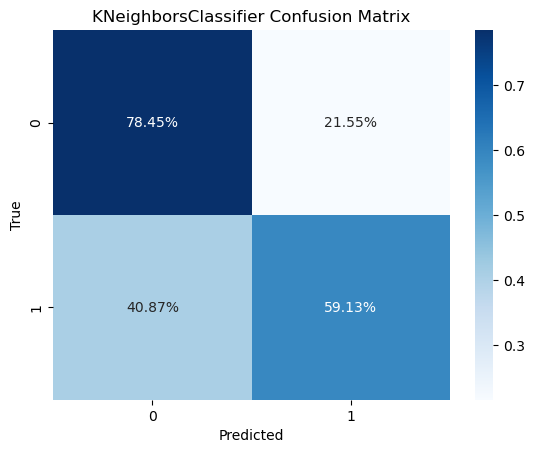

 50%|█████     | 3/6 [00:01<00:01,  1.98it/s]

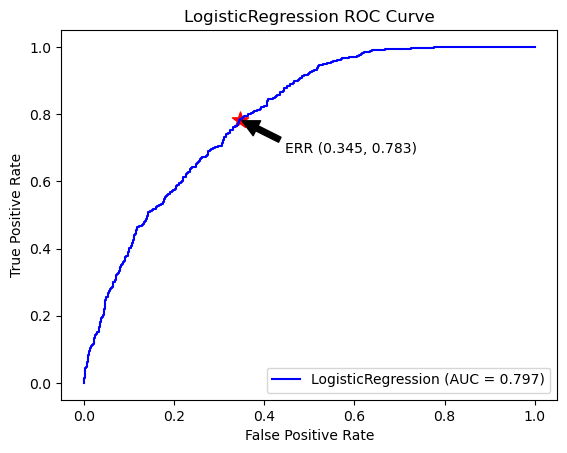

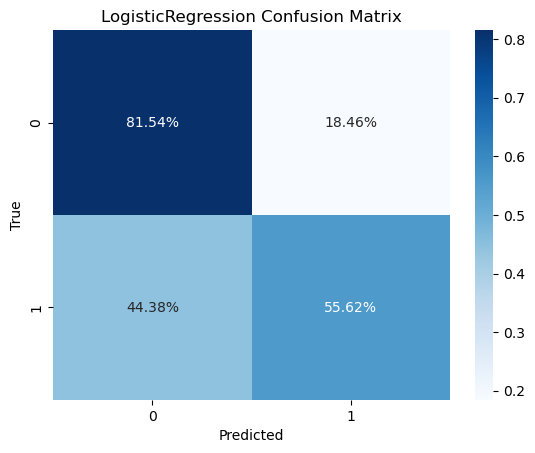

 67%|██████▋   | 4/6 [00:01<00:00,  2.14it/s]

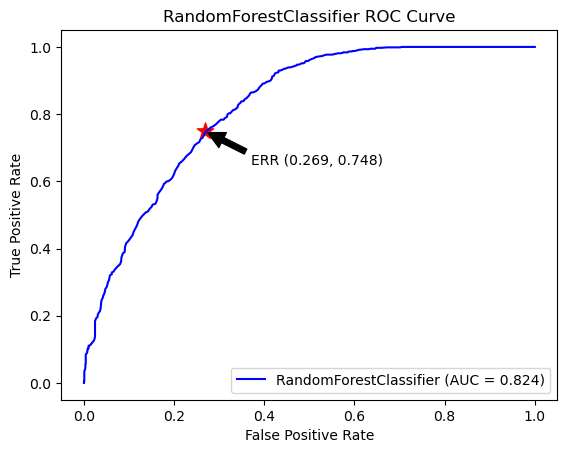

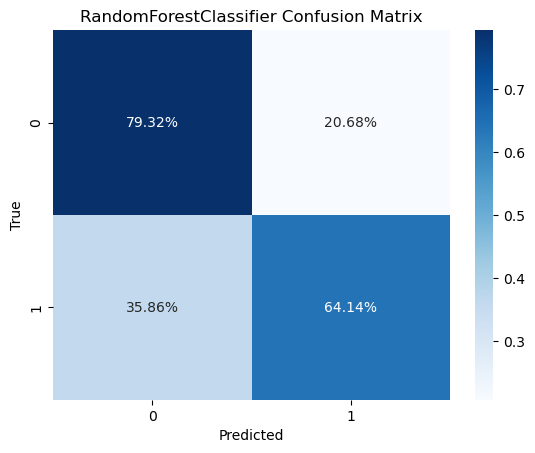

 83%|████████▎ | 5/6 [00:06<00:02,  2.14s/it]c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\19620\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, in

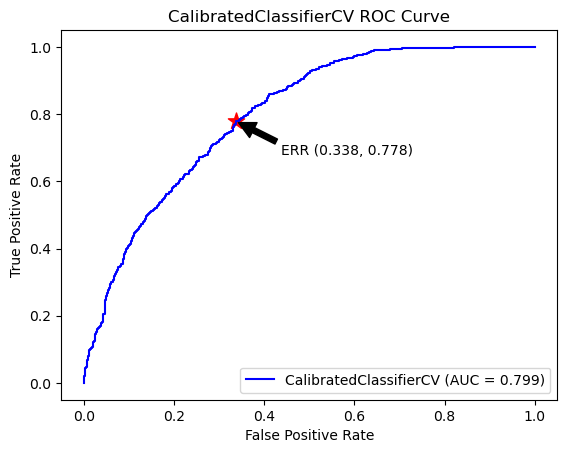

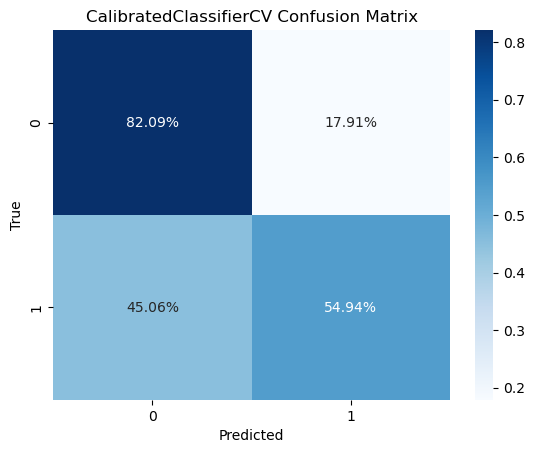

100%|██████████| 6/6 [00:09<00:00,  1.65s/it]

CPU times: total: 13.7 s
Wall time: 9.94 s


In [ ]:
%%time
from sklearn.calibration import CalibratedClassifierCV

# 创建一个空的 DataFrame 用于存储模型比较结果
model_comparison = pd.DataFrame(columns=['model','logloss','overall-accuracy','TPR','TNR','FPR','FNR'])

# 划分训练集和验证集
train_x, x_cv, train_y, y_cv = train_test_split(    x,    y,    test_size=0.25,    random_state=0)

# 创建需要比较的模型列表
models=[GaussianNB(),                                                                                   # 朴素贝叶斯模型
        LinearDiscriminantAnalysis(),                                                                   # 线性判别分析模型
        KNeighborsClassifier(n_neighbors=5),                                                            # KNN 模型
        LogisticRegression(penalty='l2', solver='liblinear'),                                           # 逻辑回归模型
        RandomForestClassifier( random_state=0, oob_score=True, n_estimators=300, criterion='gini'),    # 随机森林模型
        LinearSVC(C=1.0)                                                   # 支持向量机模型
        ]    


FPR, TPR, AUC = [], [], []

for model in tqdm(models):
        if type(model).__name__ == 'LinearSVC':
            model = CalibratedClassifierCV(model, cv=5, method='sigmoid')
        model.fit(train_x, train_y)
        y_pred_model=model.predict(x_cv)
        y_pred_model_proba = model.predict_proba(x_cv)
        y_pred_model_score = y_pred_model_proba[:, 1]
        model_comparison.loc[len(model_comparison)] = np.array([str(type(model)).split(".")[-1][:-2],
                                                                model_lg_loss(model, x_cv, y_cv),
                                                                metrics.accuracy_score(y_cv, y_pred_model),  
                                                                confusion_matrix(y_cv, y_pred_model)[1,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] ),  
                                                                confusion_matrix(y_cv, y_pred_model)[0,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ), 
                                                                confusion_matrix(y_cv, y_pred_model)[1,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ),   
                                                                confusion_matrix(y_cv, y_pred_model)[0,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] )])
        # 绘制 ROC 曲线
        fpr, tpr, thresholds = roc_curve(y_cv, y_pred_model_score)
        auc = roc_auc_score(y_cv, y_pred_model_score)
        FPR.append(fpr)
        TPR.append(tpr)
        AUC.append(auc)
        plt.plot(fpr,tpr,'b-', label= type(model).__name__ + ' (AUC = %0.3f)' % auc)
        plt.legend()
        
        # 计算 ERR
        distance = np.sqrt((1 - tpr)**2 + fpr**2)
        err_idx = np.argmin(distance)
        plt.scatter(fpr[err_idx], tpr[err_idx], marker='*', s=150, c='r')
        plt.annotate('ERR ({:.3f}, {:.3f})'.format(fpr[err_idx], tpr[err_idx]), xy=(fpr[err_idx], tpr[err_idx]), xytext=(fpr[err_idx]+0.1, tpr[err_idx]-0.1), arrowprops=dict(facecolor='black', shrink=0.05))

        # 标注
        plt.title(type(model).__name__ + " ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

        # 计算混淆矩阵
        cm = confusion_matrix(y_cv, y_pred_model, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
        plt.title(type(model).__name__ + " Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # 如果是支持向量机模型，输出支持向量以及支持向量的个数
        if type(model).__name__ == 'LinearSVC':
                support_vectors = model.support_vectors_
                print("Support Vectors are :\t", support_vectors)
                print("Number of Support Vectors are :\t", model.n_support_)     
                
                # 创建PCA模型
                pca = PCA(n_components=2)
                X_pca = pca.fit_transform(train_x)

                # 绘制支持向量和决策面
                plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_y, cmap=plt.cm.Set1, edgecolor='k')
                ax = plt.gca()
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                plt.title("Projection Results of the Support Vector")
                
                plt.show()



试试看XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import log_loss

d_train = xgb.DMatrix(train_x, label=train_y)
d_valid = xgb.DMatrix(x_cv, label=y_cv)
assert d_train.num_row() == len(train_x)
assert d_valid.num_row() == len(x_cv)
eval_set = [(d_train, 'train'), (d_valid, 'valid')]


[0]	train-logloss:0.68791	valid-logloss:0.68800
[10]	train-logloss:0.64510	valid-logloss:0.64577
[20]	train-logloss:0.61388	valid-logloss:0.61599
[30]	train-logloss:0.59029	valid-logloss:0.59367
[40]	train-logloss:0.57191	valid-logloss:0.57622
[50]	train-logloss:0.55732	valid-logloss:0.56234
[60]	train-logloss:0.54554	valid-logloss:0.55082
[70]	train-logloss:0.53593	valid-logloss:0.54223
[80]	train-logloss:0.52801	valid-logloss:0.53500
[90]	train-logloss:0.52135	valid-logloss:0.52900
[99]	train-logloss:0.51630	valid-logloss:0.52423
[0]	train-logloss:0.68737	valid-logloss:0.68761
[10]	train-logloss:0.64006	valid-logloss:0.64194
[20]	train-logloss:0.60554	valid-logloss:0.60919
[30]	train-logloss:0.57959	valid-logloss:0.58527
[40]	train-logloss:0.55983	valid-logloss:0.56682
[50]	train-logloss:0.54407	valid-logloss:0.55202
[60]	train-logloss:0.53148	valid-logloss:0.54060
[70]	train-logloss:0.52115	valid-logloss:0.53113
[80]	train-logloss:0.51270	valid-logloss:0.52382
[90]	train-logloss:0.5

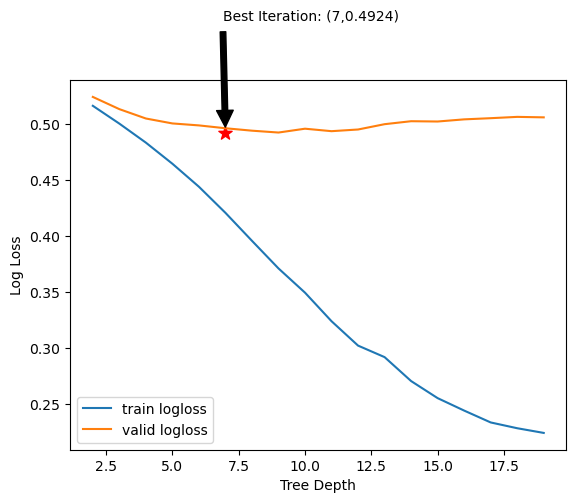

In [ ]:
# 找出最佳的树的深度
train_error_list = []
val_error_list = []

for i in range(2, 20):
    # xgboost参数设置
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.02,
        'max_depth': i
    }
    results = {}
    num_rounds = 100
    early_stopping_rounds = 5000
    bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

    train_error = results['train']['logloss']
    train_error_list.append(train_error[-1])
    val_error = results['valid']['logloss']
    val_error_list.append(val_error[-1])

best_depth = np.argmin(val_error_list)
# 绘制树的深度与logloss的关系
plt.plot(range(2, 20), train_error_list, label='train logloss')
plt.plot(range(2, 20), val_error_list, label='valid logloss')
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss')
plt.scatter(best_depth, val_error_list[best_depth], s=100, marker='*', color='red', label='Best Iteration')   # Mark the best iteration with a red star 
plt.annotate('Best Iteration: ({},{:.4f})'.format(best_depth, val_error_list[best_depth]), xy=(best_depth, val_error_list[best_depth]), xytext=(best_depth+0.5, val_error_list[best_depth]-0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

[0]	train-logloss:0.69115	valid-logloss:0.69150
[10]	train-logloss:0.67227	valid-logloss:0.67589
[20]	train-logloss:0.65508	valid-logloss:0.66185
[30]	train-logloss:0.63930	valid-logloss:0.64925
[40]	train-logloss:0.62466	valid-logloss:0.63779
[50]	train-logloss:0.61139	valid-logloss:0.62748
[60]	train-logloss:0.59900	valid-logloss:0.61777
[70]	train-logloss:0.58738	valid-logloss:0.60869
[80]	train-logloss:0.57658	valid-logloss:0.60034
[90]	train-logloss:0.56659	valid-logloss:0.59273
[99]	train-logloss:0.55815	valid-logloss:0.58629
[0]	train-logloss:0.68916	valid-logloss:0.68986
[10]	train-logloss:0.65335	valid-logloss:0.66047
[20]	train-logloss:0.62313	valid-logloss:0.63669
[30]	train-logloss:0.59769	valid-logloss:0.61678
[40]	train-logloss:0.57534	valid-logloss:0.59936
[50]	train-logloss:0.55604	valid-logloss:0.58482
[60]	train-logloss:0.53913	valid-logloss:0.57233
[70]	train-logloss:0.52368	valid-logloss:0.56137
[80]	train-logloss:0.51018	valid-logloss:0.55173
[90]	train-logloss:0.4

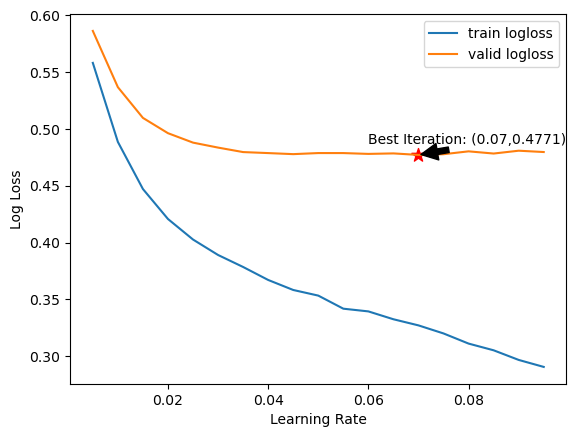

In [ ]:
# 找出最佳的学习率
train_error_list = []
val_error_list = []

for i in range(5, 100, 5):
    # xgboost参数设置
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': i/1000,
        'max_depth': best_depth
    }
    results = {}
    num_rounds = 100
    early_stopping_rounds = 5000
    bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

    train_error = results['train']['logloss']
    train_error_list.append(train_error[-1])
    val_error = results['valid']['logloss']
    val_error_list.append(val_error[-1])

eta = np.argmin(val_error_list)
best_eta = np.argmin(val_error_list) * 0.005 + 0.005
# 绘制树的深度与logloss的关系
plt.plot([i/1000 for i in range(5, 100, 5)], train_error_list, label='train logloss')
plt.plot([i/1000 for i in range(5, 100, 5)], val_error_list, label='valid logloss')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Log Loss')
plt.scatter(best_eta, val_error_list[eta], s=100, marker='*', color='red', label='Best Iteration')   # Mark the best iteration with a red star 
plt.annotate('Best Iteration: ({},{:.4f})'.format(best_eta, val_error_list[eta]), xy=(best_eta, val_error_list[eta]), xytext=(best_eta-0.02, val_error_list[eta]-0.03), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

[0]	train-logloss:0.66603	valid-logloss:0.67092
[10]	train-logloss:0.51354	valid-logloss:0.55473
[20]	train-logloss:0.44822	valid-logloss:0.51080
[30]	train-logloss:0.41335	valid-logloss:0.49199
[40]	train-logloss:0.39119	valid-logloss:0.48359
[50]	train-logloss:0.37617	valid-logloss:0.47855
[60]	train-logloss:0.36138	valid-logloss:0.47658
[70]	train-logloss:0.35306	valid-logloss:0.47660
[80]	train-logloss:0.34182	valid-logloss:0.47718
[90]	train-logloss:0.33553	valid-logloss:0.47661
[100]	train-logloss:0.32643	valid-logloss:0.47724
[110]	train-logloss:0.31370	valid-logloss:0.47750
[120]	train-logloss:0.30516	valid-logloss:0.47693
[130]	train-logloss:0.29552	valid-logloss:0.47632
[140]	train-logloss:0.28876	valid-logloss:0.47695
[150]	train-logloss:0.28179	valid-logloss:0.47704
[160]	train-logloss:0.27384	valid-logloss:0.47854
[170]	train-logloss:0.26555	valid-logloss:0.47981
[180]	train-logloss:0.25739	valid-logloss:0.48093
[190]	train-logloss:0.24924	valid-logloss:0.48230
[199]	train

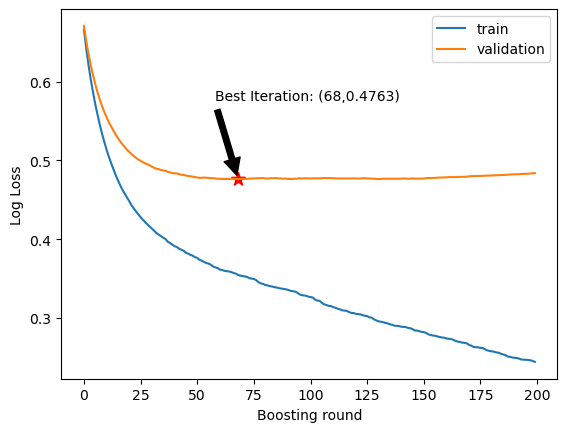

In [ ]:
# xgboost参数设置
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_eta,
    'max_depth': best_depth}


# xgboost模型训练
results = {}
num_rounds = 200
early_stopping_rounds = 5000
bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
# bst = pickle.load(open('xgb.pkl', 'rb'))

train_error = results['train']['logloss']
val_error = results['valid']['logloss']
best_iteration = np.argmin(val_error)

# 找出最佳的迭代次数
plt.plot(train_error, label='train')
plt.plot(val_error, label='validation')
plt.xlabel('Boosting round')
plt.ylabel('Log Loss')
plt.legend()
plt.scatter(best_iteration, val_error[best_iteration], s=100, marker='*', color='red', label='Best Iteration')   # Mark the best iteration with a red star 
plt.annotate('Best Iteration: ({},{:.4f})'.format(best_iteration, val_error[best_iteration]), xy=(best_iteration, val_error[best_iteration]), xytext=(best_iteration-10, val_error[best_iteration]+0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [ ]:
bst_best = xgb.train(params, d_train, num_boost_round=best_iteration, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
d_cv = xgb.DMatrix(x_cv)
y_pred = bst_best.predict(d_cv)
y_pred = bst.predict(d_cv)
y_pred_model = [1 if x > 0.5 else 0 for x in y_pred]
y_pred_model_score = 1 / (1 + np.exp(-y_pred))
model_comparison.loc[len(model_comparison) + 1] = np.array([str(type(bst)).split(".")[-1][:-2],
                                                        log_loss(d_valid.get_label(), y_pred),
                                                        metrics.accuracy_score(y_cv, y_pred_model),  
                                                        confusion_matrix(y_cv, y_pred_model)[1,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] ),  
                                                        confusion_matrix(y_cv, y_pred_model)[0,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ), 
                                                        confusion_matrix(y_cv, y_pred_model)[1,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ),   
                                                        confusion_matrix(y_cv, y_pred_model)[0,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] )])

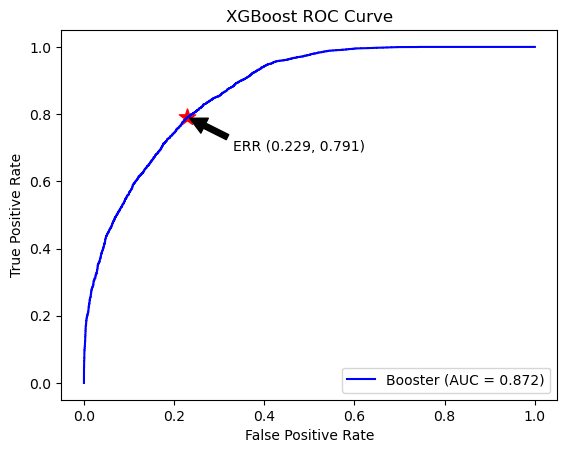

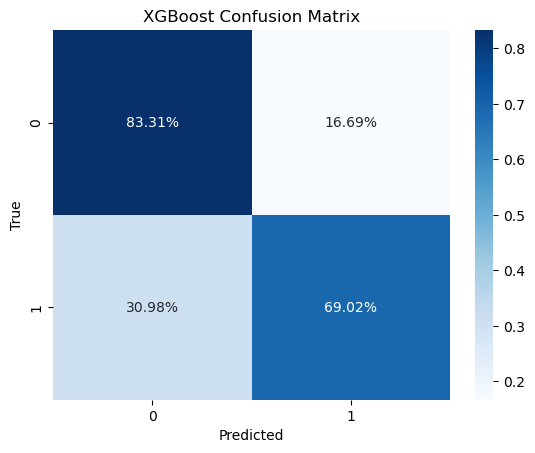

In [ ]:
# 绘制XGBoost ROC 曲线
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_model_score)
auc = roc_auc_score(y_cv, y_pred_model_score)
FPR.append(fpr)
TPR.append(tpr)
AUC.append(auc)
plt.plot(fpr,tpr,'b-', label= type(bst).__name__ + ' (AUC = %0.3f)' % auc)
plt.legend()
# 计算 ERR
distance = np.sqrt((1 - tpr)**2 + fpr**2)
err_idx = np.argmin(distance)
plt.scatter(fpr[err_idx], tpr[err_idx], marker='*', s=150, c='r')
plt.annotate('ERR ({:.3f}, {:.3f})'.format(fpr[err_idx], tpr[err_idx]), xy=(fpr[err_idx], tpr[err_idx]), xytext=(fpr[err_idx]+0.1, tpr[err_idx]-0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("XGBoost ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# 计算XGBoost混淆矩阵
cm = confusion_matrix(y_cv, y_pred_model, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

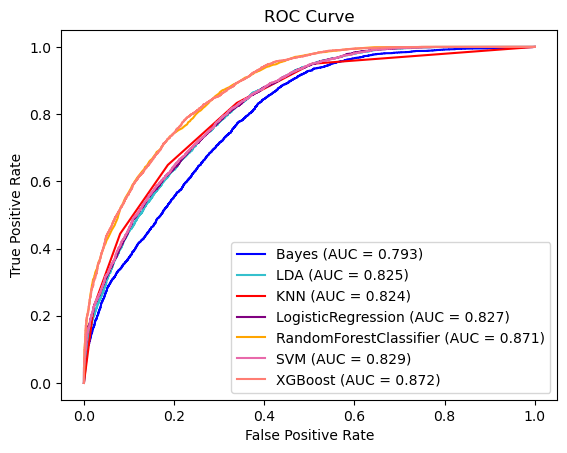

Model Comparison Done!


model              logloss    overall-accuracy  \
0                  GaussianNB  0.39537148585499715  0.7003052612677321   
1  LinearDiscriminantAnalysis  0.25692103059839283  0.7400790087987071   
2        KNeighborsClassifier  0.31512805481178785  0.7530077213144191   
3          LogisticRegression   0.2505393379872574  0.7432214042018316   
4      RandomForestClassifier  0.21006739872945315  0.7820973244747711   
5      CalibratedClassifierCV   0.2518330667623939   0.744747710540492   
7                     Booster   0.4167357576440698  0.7803914526845035   

                  TPR                 TNR                  FPR  \
0  0.5685333333333333  0.6547161758429364   0.1296059183383127   
1  0.6681440443213297  0.8295632380139423  0.24142836818893157   
2  0.6708605938600906  0.8139137857447717   0.2052923602219377   
3  0.6722758620689655  0.8309859154929577   0.2378716744913928   
4  0.7146503318019398  0.8409446578460663  0.18622848200312989   
5  0.6765197992191857  0.8349694124342012  0.23943661971830985   
7   0.707408331254677   0.833119931711481  0.18110684307867406   

                   FNR  
0  0.43146666666666667  
1   0.3318559556786704  
2   0.3291394061399094  
3   0.3277241379310345  
4  0.28534966819806024  
5   0.3234802007808143  
7    0.292591668745323

In [ ]:
# 绘制所有模型的 ROC 曲线
plt.plot(FPR[0],TPR[0],'b-', label='Bayes (AUC = %0.3f)' % AUC[0])
plt.plot(FPR[1],TPR[1],'#35C0CD', label='LDA (AUC = %0.3f)' % AUC[1])
plt.plot(FPR[2],TPR[2],'r-', label='KNN (AUC = %0.3f)' % AUC[2])
plt.plot(FPR[3],TPR[3],'purple', label='LogisticRegression (AUC = %0.3f)' % AUC[3])
plt.plot(FPR[4],TPR[4],'orange', label='RandomForestClassifier (AUC = %0.3f)' % AUC[4])
plt.plot(FPR[5],TPR[5],'#E869AA', label='SVM (AUC = %0.3f)' % AUC[5])
plt.plot(FPR[6],TPR[6],'#FF7D73', label='XGBoost (AUC = %0.3f)' % AUC[6])
plt.legend()
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print("Model Comparison Done!")

model_comparison

16. 改变阈值以最小化假复制

17. K折交叉验证

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

10 -Fold Cross validation Done!


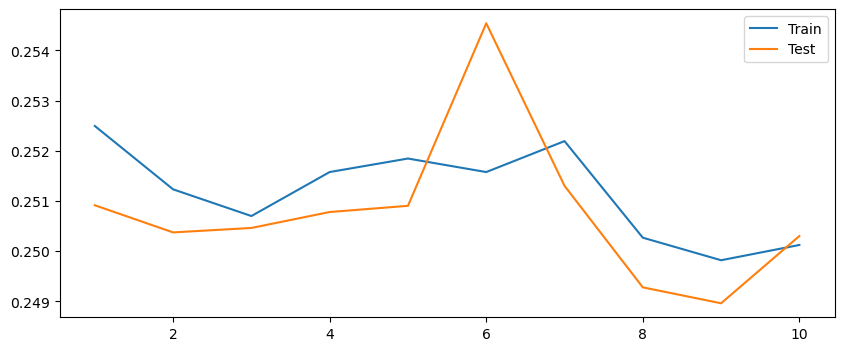

CPU times: total: 32.5 s
Wall time: 11.7 s


In [ ]:
%%time

# 导入逻辑回归模型
model = LogisticRegression(penalty='l2', solver='liblinear')

# 定义变量
train_x,test_x,train_y,test_y=[None]*4
num_shuffles=10

# 定义保存结果的dataframe
shuffled = pd.DataFrame(columns=['Shuffle No','train_logloss','cv_logloss','train_accuracy','cv_accuracy','train_recall','cv_recall','train_precision','cv_precision','train_f1score','cv_f1score','train_auc','cv_auc'])

# 开始num_shuffles次随机分组
for i in tqdm(range(num_shuffles)):
    # 随机分组
    train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=None,test_size=0.2,shuffle=True)
    # 在训练集上拟合模型
    model.fit(train_x,train_y)
  
    # 在训练集上预测结果，并计算准确率
    y_pred = model.predict(train_x)
    accuracy_train = sum([y_pred==train_y][0].values)/len(train_y)
    
    # 计算训练集的召回率、精确率、F1分数和AUC
    tr_precision = precision_score(train_y, y_pred)
    tr_recall = recall_score(train_y, y_pred)
    tr_f1score = f1_score(train_y, y_pred)
    tr_auc = roc_auc_score(train_y, y_pred)

    # 计算训练集的召回率、精确率、F1分数和AUC
    y_pred = model.predict(test_x)
    accuracy_cv = sum([y_pred==test_y][0].values)/len(test_y)

    # 计算训练集的召回率、精确率、F1分数和AUC
    cv_precision = precision_score(test_y, y_pred)
    cv_recall = recall_score(test_y, y_pred)
    cv_f1score = f1_score(test_y, y_pred)
    cv_auc = roc_auc_score(test_y, y_pred)
    
    # 计算训练集和测试集的logloss
    train_logloss = log_loss(model.predict(train_x), train_y)
    test_logloss = log_loss(model.predict(x_cv), y_cv)

    # 将结果保存到dataframe中
    shuffled.loc[len(shuffled.index)]=[int(i+1), model_lg_loss(model, train_x, train_y) ,model_lg_loss(model, x_cv, y_cv) ,  accuracy_train, accuracy_cv, tr_recall, cv_recall, tr_precision, cv_precision, tr_f1score, cv_f1score, tr_auc, cv_auc]

# 显示结果
shuffled.head(5)
print(num_shuffles,"-Fold Cross validation Done!")

# 可视化训练集和测试集的logloss
fig = plt.figure(figsize =(10, 4))
plt.plot(shuffled['Shuffle No'],shuffled['train_logloss'], label='Train')
plt.plot(shuffled['Shuffle No'],shuffled['cv_logloss'], label='Test')
plt.legend()
plt.show()

19. 测试数据导入

In [ ]:
df_test =  pd.read_csv('./dataset/quora-question-pairs/test_dev.csv')
print(df_test.shape)
print("Test Data imported")
df_test.head(2)

(101, 3)
Test Data imported


test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?

In [ ]:
df_test.isna().sum()  # 计算每列缺失值的数量

test_id      0
question1    0
question2    0
dtype: int64

20. 测试数据集中缺少值

In [ ]:
df_test.loc[df_test.isnull().any(axis=1),:]

Empty DataFrame
Columns: [test_id, question1, question2]
Index: []

In [ ]:
df_test = df_test.fillna("Unknown")     # 将缺失值用unkown代替
df_test.isna().sum(), df_test.shape

(test_id      0
 question1    0
 question2    0
 dtype: int64,
 (101, 3))

21. 测试集中独特和重复问题的分析

In [ ]:
dff = df_test.copy()
dff.loc[:,'question1'] = dff.loc[:,'question1'].str.strip()
dff.loc[:,'question2'] = dff.loc[:,'question2'].str.strip()
questions_list = pd.concat([dff['question1'] , dff['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in Test dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  202
Number of Questions which are repeated:  0
Total number of unique questions in Test dataset:  202


22. 测试数据：文本预处理

In [ ]:
%%time
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",     "aren't": "are not",         "can't": "can not",         "can't've": "can not have",
    "'cause": "because",   "could've": "could have",    "couldn't": "could not",    "couldn't've": "could not have",
    "didn't": "did not",   "doesn't": "does not",       "don't": "do not",          "hadn't": "had not",
    "hadn't've": "had not have",    "hasn't": "has not","haven't": "have not",      "he'd": "he would",
    "he'd've": "he would have",     "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did",    "how'd'y": "how do you",     "how'll": "how will",       "how's": "how is",
    "i'd": "i would",      "i'd've": "i would have",    "i'll": "i will",           "i'll've": "i will have",
    "i'm": "i am",         "i've": "i have",            "isn't": "is not",          "it'd": "it would",
    "it'd've": "it would have",     "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us",     "ma'am": "madam",            "mayn't": "may not",        "might've": "might have",
    "mightn't": "might not",        "mightn't've": "might not have",                "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",  "needn't": "need not",   "needn't've": "need not have",
    "o'clock": "of the clock",    "oughtn't": "ought not", "oughtn't've": "ought not have","shan't": "shall not",
    "sha'n't": "shall not","shan't've": "shall not have",  "she'd": "she would",    "she'd've": "she would have",
    "she'll": "she will",  "she'll've": "she will have",   "she's": "she is",       "should've": "should have",
    "shouldn't": "should not","shouldn't've": "should not have","so've": "so have", "so's": "so as",
    "that'd": "that would","that'd've": "that would have", "that's": "that is",     "there'd": "there would",
    "there'd've": "there would have","there's": "there is","they'd": "they would",  "they'd've": "they would have",
    "they'll": "they will","they'll've": "they will have", "they're": "they are",
    "they've": "they have","to've": "to have",    "wasn't": "was not",    "we'd": "we would","we'd've": "we would have",
    "we'll": "we will",    "we'll've": "we will have",    "we're": "we are","we've": "we have","weren't": "were not",
    "what'll": "what will",    "what'll've": "what will have",    "what're": "what are",    "what's": "what is",
    "what've": "what have",    "when's": "when is",    "when've": "when have",    "where'd": "where did",
    "where's": "where is",    "where've": "where have",    "who'll": "who will",    "who'll've": "who will have",
    "who's": "who is",    "who've": "who have",    "why's": "why is",    "why've": "why have",    "will've": "will have",
    "won't": "will not",    "won't've": "will not have",    "would've": "would have",    "wouldn't": "would not",
    "wouldn't've": "would not have",    "y'all": "you all",    "y'all'd": "you all would",    "y'all'd've": "you all would have",
    "y'all're": "you all are",    "y'all've": "you all have",    "you'd": "you would",    "you'd've": "you would have",
    "you'll": "you will",    "you'll've": "you will have",    "you're": "you are",    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

dff['question1'] = dff['question1'].apply(preprocess)
dff['question2'] = dff['question2'].apply(preprocess)
print("Test Data Pre-Processing Done!")

Test Data Pre-Processing Done!
CPU times: total: 31.2 ms
Wall time: 55.5 ms


23. 问题聚类

In [ ]:
%%time
test_document_corpus = list(set(list(dff['question1']) + list(dff['question2'])))
test_questions_cluster = pd.DataFrame({'questions': test_document_corpus , 'cluster_label':None})
x = vectorizer.fit_transform(test_questions_cluster['questions'].values)
vectorizer = TfidfVectorizer()
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
test_questions_cluster['cluster_label'] = km.labels_
test_questions_cluster.head(3)

CPU times: total: 18.2 s
Wall time: 1.83 s


questions  cluster_label
0  if i like a comment to a computer post by a fr...              1
1  is the usa chocolate covered strawberries have...              5
2               what does it feel like to watch porn              0

In [ ]:
# 将聚类得到的结果合并到原始数据中
dff = pd.merge( left=pd.merge(left=dff, right=test_questions_cluster, left_on="question1", right_on="questions"), right=test_questions_cluster , left_on="question2", right_on="questions")
dff.drop(["questions_x","questions_y"], axis=1, inplace=True)
dff.rename(columns={'cluster_label_x':'q1_cluster','cluster_label_y':'q2_cluster'}, inplace=True)
print("Test Questions Clusters Labelled")
dff.head(4)

Test Questions Clusters Labelled


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   
2        2  what but is the best way to send money from ch...   
3        3                         which food not emulsifiers   

                                           question2  q1_cluster  q2_cluster  
0  why did microsoft choose core m3 and not core ...           8           6  
1         how much cost does hair transplant require           5           8  
2                       what you send money to china           5           8  
3                                   what foods fibre           5           7

In [ ]:
dff.columns

Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster'], dtype='object')

24. 基本文本特征工程

In [ ]:
%%time
from fuzzywuzzy import fuzz
import sys

dff = pd.merge( pd.merge(dff,pd.DataFrame({'question1':dff['question1'].value_counts().index.values,'freq_qid1':dff['question1'].value_counts().values}), on='question1',how="left"),pd.DataFrame({'question2':dff['question2'].value_counts().index.values,'freq_qid2':dff['question2'].value_counts().values}) ,on='question2', how='left')
dff.loc[:,['q1_length']] = dff['question1'].apply(lambda x: len(x)).values
dff.loc[:,['q2_length']] = dff['question2'].apply(lambda x: len(x)).values
dff['same_cluster'] = dff[['q1_cluster','q2_cluster']].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)
dff['q1_wordsCount'] = dff['question1'].apply(lambda x: len(x.split(" ")))
dff['q2_wordsCount'] = dff['question2'].apply(lambda x: len(x.split(" ")))
dff['common_wordsCount'] = dff[['question1','question2']].apply(lambda x: len(set(x[0].split(" ")).intersection(set(x[1].split(" ")))) , axis=1 )
dff['q1_freq+q2_freq'] = dff['freq_qid1']+dff['freq_qid2']
dff['q1_freq-q2_freq'] = abs(dff['freq_qid1']-dff['freq_qid2'])
dff['total_word_share'] = 2*dff['common_wordsCount']/(dff['q1_wordsCount']+dff['q2_wordsCount'])
print("Test Basic Feature Engineering Done!")
dff.head(2)

Test Basic Feature Engineering Done!
CPU times: total: 15.6 ms
Wall time: 18 ms


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           8           6   
1         how much cost does hair transplant require           5           8   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  q1_wordsCount  \
0          1          1         56         67             0             11   
1          1          1         65         42             0             15   

   q2_wordsCount  common_wordsCount  q1_freq+q2_freq  q1_freq-q2_freq  \
0             14                  3                2                0   
1              7                  5                2                0   

   total_word_share  
0          0.240000  
1          0.454545

25. 测试数据中的高级文本特征工程

In [ ]:
%%time
import distance

STOP_WORDS = stopwords.words("english")
epsilon = 0.001
       
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def advanced_featureExtract(q1,q2):
    
    q1_tokens = q1.split(" ")
    q2_tokens = q2.split(" ")
    
    q1_stopwords = [word for word in q1_tokens if word in STOP_WORDS]
    q2_stopwords = [word for word in q2_tokens if word in STOP_WORDS]
    
    q1_words = [word for word in q1_tokens if word not in STOP_WORDS]
    q2_words = [word for word in q2_tokens if word not in STOP_WORDS]
        
    common_words = list(set(q1_words).intersection(set(q2_words)))
    common_stopwords = list(set(q1_stopwords).intersection(set(q2_stopwords)))
    common_tokens = list(set(q1_tokens).intersection(set(q2_tokens)))
    
    com_words_count_min = len(common_words)/(epsilon + min(len(q2_words), len(q1_words)) )
    com_words_count_max = len(common_words)/(epsilon + max(len(q2_words), len(q1_words)) )
    
    com_stopwords_count_min = len(common_words)/(epsilon + min(len(q2_stopwords), len(q1_stopwords)) )
    com_stopwords_count_max = len(common_stopwords)/(epsilon + max(len(q2_stopwords), len(q1_stopwords)) )
    
    com_token_count_min = len(common_tokens)/(epsilon + min(len(q2_tokens), len(q1_tokens)) )
    com_token_count_max = len(common_tokens)/(epsilon + max(len(q2_tokens), len(q1_tokens)) )
    
    last_word_eq  = 1 if q2_tokens[-1] == q1_tokens[-1] else 0
    first_word_eq = 1 if q2_tokens[0]  == q1_tokens[0]  else 0
    
    abs_len_diff = abs(len(q2_tokens) - len(q1_tokens))
    mean_len = (len(q2_tokens) + len(q1_tokens))/2
    
    longest_substring_ratio = get_longest_substr_ratio(q1, q2)
    
    return com_words_count_min, com_words_count_max, com_stopwords_count_min,  com_stopwords_count_max, com_token_count_min, com_token_count_max,  last_word_eq, first_word_eq, abs_len_diff, mean_len, longest_substring_ratio
       
token_features = dff.apply(lambda x: advanced_featureExtract(x["question1"], x["question2"]), axis=1)

dff["cwc_min"]       = list(map(lambda x: x[0], token_features))
dff["cwc_max"]       = list(map(lambda x: x[1], token_features))
dff["csc_min"]       = list(map(lambda x: x[2], token_features))
dff["csc_max"]       = list(map(lambda x: x[3], token_features))
dff["ctc_min"]       = list(map(lambda x: x[4], token_features))
dff["ctc_max"]       = list(map(lambda x: x[5], token_features))
dff["last_word_eq"]  = list(map(lambda x: x[6], token_features))
dff["first_word_eq"] = list(map(lambda x: x[7], token_features))
dff["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
dff["mean_len"]      = list(map(lambda x: x[9], token_features))
dff["longest_substring_ratio"] = list(map(lambda x: x[10], token_features))
print("Test Data Advanced Feature Engineering Done!")
dff.head(2)

AttributeError: 'numpy.ndarray' object has no attribute 'lcsubstrings'

In [ ]:
dff.columns

Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster',
       'freq_qid1', 'freq_qid2', 'q1_length', 'q2_length', 'same_cluster',
       'q1_wordsCount', 'q2_wordsCount', 'common_wordsCount',
       'q1_freq+q2_freq', 'q1_freq-q2_freq', 'total_word_share', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substring_ratio'],
      dtype='object')

26. 从测试数据中提取的模糊文本相似度

In [ ]:
%%time
dff['fuzz_ratio']           = dff[['question1','question2']].apply(lambda x: fuzz.ratio(           x[0],x[1]), axis=1)
dff['fuzz_partial_ratio']   = dff[['question1','question2']].apply(lambda x: fuzz.partial_ratio(   x[0],x[1]), axis=1)
dff['fuzz_token_sort_ratio']= dff[['question1','question2']].apply(lambda x: fuzz.token_sort_ratio(x[0],x[1]), axis=1)
dff['fuzz_token_set_ratio'] = dff[['question1','question2']].apply(lambda x: fuzz.token_set_ratio( x[0],x[1]), axis=1)
dff['fuzz_WRatio']          = dff[['question1','question2']].apply(lambda x: fuzz.WRatio(          x[0],x[1]), axis=1)
print("Test Fuzzy Ratios Done!")
dff.head(2) 

Test Fuzzy Ratios Done!
CPU times: total: 15.6 ms
Wall time: 32 ms


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           5           6   
1         how much cost does hair transplant require           2           1   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  ...  \
0          1          1         56         67             0  ...   
1          1          1         65         42             0  ...   

   last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0             0              0             3      12.5   
1             0              0             8      11.0   

   longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
0                 0.245614          46                  45   
1                 0.395349          49                  57   

   fuzz_token_sort_ratio  fuzz_token_set_ratio  fuzz_WRatio  
0                     55                    58           55  
1                     58                    82           86  

[2 rows x 32 columns]

27. 为测试数据提取余弦相似性

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

document_corpus = list(dff['question1'])+list(dff['question2'])
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(document_corpus)
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

dff['cosine_similarity'] = ques_pair_vectors
print("Test Data Cosine Similarity Extracted!")
print("Columns: ",dff.columns)
dff.head(2)

100%|██████████| 101/101 [00:00<00:00, 3607.01it/s]

Test Data Cosine Similarity Extracted!
Columns:  Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster',
       'freq_qid1', 'freq_qid2', 'q1_length', 'q2_length', 'same_cluster',
       'q1_wordsCount', 'q2_wordsCount', 'common_wordsCount',
       'q1_freq+q2_freq', 'q1_freq-q2_freq', 'total_word_share', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substring_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'fuzz_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_WRatio', 'cosine_similarity'],
      dtype='object')
CPU times: total: 15.6 ms
Wall time: 39 ms


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           5           6   
1         how much cost does hair transplant require           2           1   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  ...  \
0          1          1         56         67             0  ...   
1          1          1         65         42             0  ...   

   first_word_eq  abs_len_diff  mean_len  longest_substring_ratio  fuzz_ratio  \
0              0             3      12.5                 0.245614          46   
1              0             8      11.0                 0.395349          49   

   fuzz_partial_ratio  fuzz_token_sort_ratio  fuzz_token_set_ratio  \
0                  45                     55                    58   
1                  57                     58                    82   

   fuzz_WRatio  cosine_similarity  
0           55           0.252460  
1           86           0.560234  

[2 rows x 33 columns]

28. 在训练数据集上训练随机森林分类器

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
x= df.copy()
x.drop(['id','qid1','qid2','question1','question2','is_duplicate','q1_cluster', 'q2_cluster'], axis=1, inplace=True)
sc_x = StandardScaler()
x.insert(loc=0, column='x0', value=[1]*len(x))
x.iloc[:,1:-1] = sc_x.fit_transform(x.iloc[:,1:-1])
y=df['is_duplicate'].apply(lambda x: 0 if x=="No" else 1)

model = RandomForestClassifier( random_state=0, oob_score=True, n_estimators=300, criterion='gini')
model.fit(x,y)
y_pred = model.predict(x)
print("Logloss of Logistic Model: ", log_loss(model.predict(x), y))
print("Training Model Done!")

Logloss of Logistic Model:  2.220446049250313e-16
Training Model Done!


29. 测试集和提交预测

In [ ]:
from sklearn.preprocessing import StandardScaler
xx= dff.copy()
xx.drop(['test_id','question1','question2','q1_cluster', 'q2_cluster'], axis=1, inplace=True)
sc_x = StandardScaler()
xx.insert(loc=0, column='x0', value=[1]*len(xx))
xx.iloc[:,1:-1] = sc_x.fit_transform(xx.iloc[:,1:-1])
prob = model.predict_proba(xx)
print("Prediction Test Data Done!")

Prediction Test Data Done!


In [ ]:
dff['is_duplicate']=pd.DataFrame(prob).iloc[:,1].values
submission =dff.loc[:,['test_id','is_duplicate']].copy()
# submission.to_csv('submission.csv',index=False)
# print("Submission File printed !")
submission

test_id  is_duplicate
0          0      0.316667
1          1      0.626667
2          2      0.606667
3          3      0.033333
4          4      0.466667
..       ...           ...
96        96      0.000000
97        97      0.430000
98        98      0.066667
99        99      0.216667
100      100      0.026667

[101 rows x 2 columns]